In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=c79f712563f2de9a239c7474ac059016f1e7f4b575c5f2b3584273fd8b0c5389
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]

symbols_list = nifty50['Symbol'].unique().tolist()

symbols_list = [symbol + '.NS' for symbol in symbols_list]

print(symbols_list)

nifty50['Symbol'] = nifty50['Symbol'].str.replace('-', '_')
nifty50['Symbol'] = nifty50['Symbol'].str.replace('&', '_')

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']


In [ ]:
end_date = '2024-04-14'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  50 of 50 completed


Price                       adj close        close         high          low  \
date       ticker                                                              
2016-04-18 ADANIENT.NS      44.287750    45.199554    45.662724    44.245979   
           ADANIPORTS.NS   222.137070   231.300003   236.750000   228.050003   
           APOLLOHOSP.NS  1327.884888  1361.349976  1366.000000  1337.000000   
           ASIANPAINT.NS   838.468933   885.200012   886.549988   875.000000   
           AXISBANK.NS     435.184052   445.250000   446.049988   437.399994   
...                               ...          ...          ...          ...   
2024-04-12 TCS.NS         4001.399902  4001.399902  4013.350098  3945.500000   
           TECHM.NS       1242.099976  1242.099976  1269.750000  1238.000000   
           TITAN.NS       3619.300049  3619.300049  3694.800049  3609.449951   
           ULTRACEMCO.NS  9652.549805  9652.549805  9850.000000  9610.000000   
           WIPRO.NS        470.750000   470.750000   480.000000   470.000000   

Price                            open     volume  
date       ticker                                 
2016-04-18 ADANIENT.NS      44.273224  6639271.0  
           ADANIPORTS.NS   235.850006  5479038.0  
           APOLLOHOSP.NS  1350.750000   274622.0  
           ASIANPAINT.NS   884.250000   685762.0  
           AXISBANK.NS     444.950012  6674315.0  
...                               ...        ...  
2024-04-12 TCS.NS         3971.000000  4354821.0  
           TECHM.NS       1264.949951  2887322.0  
           TITAN.NS       3689.550049  1910561.0  
           ULTRACEMCO.NS  9789.950195   440963.0  
           WIPRO.NS        475.000000  6585023.0  

[97876 rows x 6 columns]

In [ ]:
#Technical Indicators

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['ruppee_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                       adj close        close         high          low  \
date       ticker                                                              
2016-04-18 ADANIENT.NS      44.287750    45.199554    45.662724    44.245979   
           ADANIPORTS.NS   222.137070   231.300003   236.750000   228.050003   
           APOLLOHOSP.NS  1327.884888  1361.349976  1366.000000  1337.000000   
           ASIANPAINT.NS   838.468933   885.200012   886.549988   875.000000   
           AXISBANK.NS     435.184052   445.250000   446.049988   437.399994   
...                               ...          ...          ...          ...   
2024-04-12 TCS.NS         4001.399902  4001.399902  4013.350098  3945.500000   
           TECHM.NS       1242.099976  1242.099976  1269.750000  1238.000000   
           TITAN.NS       3619.300049  3619.300049  3694.800049  3609.449951   
           ULTRACEMCO.NS  9652.549805  9652.549805  9850.000000  9610.000000   
           WIPRO.NS        470.750000   470.750000   480.000000   470.000000   

Price                            open     volume       atr  garman_klass_vol  \
date       ticker                                                              
2016-04-18 ADANIENT.NS      44.273224  6639271.0       NaN          0.000497   
           ADANIPORTS.NS   235.850006  5479038.0       NaN         -0.000685   
           APOLLOHOSP.NS  1350.750000   274622.0       NaN          0.000118   
           ASIANPAINT.NS   884.250000   685762.0       NaN         -0.001006   
           AXISBANK.NS     444.950012  6674315.0       NaN          0.000001   
...                               ...        ...       ...               ...   
2024-04-12 TCS.NS         3971.000000  4354821.0  1.577376          0.000123   
           TECHM.NS       1264.949951  2887322.0  0.284990          0.000192   
           TITAN.NS       3689.550049  1910561.0  2.073647          0.000130   
           ULTRACEMCO.NS  9789.950195   440963.0  1.617241          0.000227   
           WIPRO.NS        475.000000  6585023.0  0.847070          0.000190   

Price                           rsi    bb_low    bb_mid   bb_high      macd  \
date       ticker                                                             
2016-04-18 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2024-04-12 TCS.NS         51.044412  8.238487  8.291328  8.344169 -0.805206   
           TECHM.NS       43.883352  7.118020  7.141481  7.164942 -0.632549   
           TITAN.NS       45.578154  8.175639  8.212791  8.249942 -0.187154   
           ULTRACEMCO.NS  45.991351  9.148792  9.183205  9.217619 -0.220651   
           WIPRO.NS       40.174997  6.138728  6.194348  6.249967 -1.198616   

Price                     ruppee_volume  
date       ticker                        
2016-04-18 ADANIENT.NS       294.038376  
           ADANIPORTS.NS    1217.097446  
           APOLLOHOSP.NS     364.666404  
           ASIANPAINT.NS     574.990133  
           AXISBANK.NS      2904.555443  
...                                 ...  
2024-04-12 TCS.NS          17425.380324  
           TECHM.NS         3586.342586  
           TITAN.NS         6914.893521  
           ULTRACEMCO.NS    4256.417320  
           WIPRO.NS         3099.899577  

[97876 rows x 14 columns]

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['ruppee_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

last_cols

['adj close',
 'atr',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'macd']

In [ ]:
data = (pd.concat([df.unstack('ticker')['ruppee_volume'].resample('M').mean().stack('ticker').to_frame('ruppee_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

ruppee_volume    adj close       atr   bb_high  \
date       ticker                                                          
2016-05-31 ADANIENT.NS       218.721644    38.895264 -0.764520  3.774221   
           ADANIPORTS.NS    1663.512618   184.538025 -0.981411  5.290309   
           APOLLOHOSP.NS     288.833151  1335.444214 -0.865980  7.209369   
           ASIANPAINT.NS    1097.128244   932.858154 -1.221363  6.878671   
           AXISBANK.NS      4038.640487   503.552704 -0.946232  6.245535   
...                                 ...          ...       ...       ...   
2024-04-30 TCS.NS          10290.146765  4001.399902  1.577376  8.344169   
           TECHM.NS         2086.635475  1242.099976  0.284990  7.164942   
           TITAN.NS         3430.048110  3619.300049  2.073647  8.249942   
           ULTRACEMCO.NS    3208.797794  9652.549805  1.617241  9.217619   
           WIPRO.NS         3082.607328   470.750000  0.847070  6.249967   

                            bb_low    bb_mid  garman_klass_vol      macd  \
date       ticker                                                          
2016-05-31 ADANIENT.NS    3.631119  3.702670         -0.000033 -0.190408   
           ADANIPORTS.NS  5.118457  5.204383          0.000555 -1.055424   
           APOLLOHOSP.NS  7.139597  7.174483         -0.000084 -0.099398   
           ASIANPAINT.NS  6.711305  6.794988         -0.001162  0.665850   
           AXISBANK.NS    6.108947  6.177241         -0.000074  0.734226   
...                            ...       ...               ...       ...   
2024-04-30 TCS.NS         8.238487  8.291328          0.000123 -0.805206   
           TECHM.NS       7.118020  7.141481          0.000192 -0.632549   
           TITAN.NS       8.175639  8.212791          0.000130 -0.187154   
           ULTRACEMCO.NS  9.148792  9.183205          0.000227 -0.220651   
           WIPRO.NS       6.138728  6.194348          0.000190 -1.198616   

                                rsi  
date       ticker                    
2016-05-31 ADANIENT.NS    40.955781  
           ADANIPORTS.NS  40.784210  
           APOLLOHOSP.NS  54.863304  
           ASIANPAINT.NS  68.917449  
           AXISBANK.NS    67.194353  
...                             ...  
2024-04-30 TCS.NS         51.044412  
           TECHM.NS       43.883352  
           TITAN.NS       45.578154  
           ULTRACEMCO.NS  45.991351  
           WIPRO.NS       40.174997  

[4760 rows x 9 columns]

In [ ]:
data['ruppee_volume'] = (data.loc[:, 'ruppee_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['ruppee_vol_rank'] = (data.groupby('date')['ruppee_volume'].rank(ascending=False))

data = data.drop(['ruppee_volume' ,'ruppee_vol_rank'],axis = 1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2016-05-31 ADANIENT.NS      38.895264 -0.764520  3.774221  3.631119  3.702670   
           ADANIPORTS.NS   184.538025 -0.981411  5.290309  5.118457  5.204383   
           APOLLOHOSP.NS  1335.444214 -0.865980  7.209369  7.139597  7.174483   
           ASIANPAINT.NS   932.858154 -1.221363  6.878671  6.711305  6.794988   
           AXISBANK.NS     503.552704 -0.946232  6.245535  6.108947  6.177241   
...                               ...       ...       ...       ...       ...   
2024-04-30 TCS.NS         4001.399902  1.577376  8.344169  8.238487  8.291328   
           TECHM.NS       1242.099976  0.284990  7.164942  7.118020  7.141481   
           TITAN.NS       3619.300049  2.073647  8.249942  8.175639  8.212791   
           ULTRACEMCO.NS  9652.549805  1.617241  9.217619  9.148792  9.183205   
           WIPRO.NS        470.750000  0.847070  6.249967  6.138728  6.194348   

                          garman_klass_vol      macd        rsi  
date       ticker                                                
2016-05-31 ADANIENT.NS           -0.000033 -0.190408  40.955781  
           ADANIPORTS.NS          0.000555 -1.055424  40.784210  
           APOLLOHOSP.NS         -0.000084 -0.099398  54.863304  
           ASIANPAINT.NS         -0.001162  0.665850  68.917449  
           AXISBANK.NS           -0.000074  0.734226  67.194353  
...                                    ...       ...        ...  
2024-04-30 TCS.NS                 0.000123 -0.805206  51.044412  
           TECHM.NS               0.000192 -0.632549  43.883352  
           TITAN.NS               0.000130 -0.187154  45.578154  
           ULTRACEMCO.NS          0.000227 -0.220651  45.991351  
           WIPRO.NS               0.000190 -1.198616  40.174997  

[4760 rows x 8 columns]

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2017-05-31 ADANIENT.NS      62.360569 -0.719498  4.219581  4.096614  4.158098   
           ADANIPORTS.NS   325.570587 -0.530420  5.857411  5.760204  5.808808   
           APOLLOHOSP.NS  1181.328369 -0.954591  7.172697  7.052727  7.112712   
           ASIANPAINT.NS  1098.967773 -0.903931  7.031233  6.954553  6.992893   
           AXISBANK.NS     507.126862 -1.069351  6.250559  6.185811  6.218185   
...                               ...       ...       ...       ...       ...   
2024-04-30 TCS.NS         4001.399902  1.577376  8.344169  8.238487  8.291328   
           TECHM.NS       1242.099976  0.284990  7.164942  7.118020  7.141481   
           TITAN.NS       3619.300049  2.073647  8.249942  8.175639  8.212791   
           ULTRACEMCO.NS  9652.549805  1.617241  9.217619  9.148792  9.183205   
           WIPRO.NS        470.750000  0.847070  6.249967  6.138728  6.194348   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-05-31 ADANIENT.NS            0.000725 -0.170783  49.905864   0.072052   
           ADANIPORTS.NS         -0.000518 -0.188829  50.679149   0.034483   
           APOLLOHOSP.NS          0.000214 -0.325411  45.898003  -0.017961   
           ASIANPAINT.NS         -0.000936  0.071482  58.333474   0.027444   
           AXISBANK.NS            0.000010 -0.062394  53.918106   0.008633   
...                                    ...       ...        ...        ...   
2024-04-30 TCS.NS                 0.000123 -0.805206  51.044412   0.032273   
           TECHM.NS               0.000192 -0.632549  43.883352  -0.004807   
           TITAN.NS               0.000130 -0.187154  45.578154  -0.048004   
           ULTRACEMCO.NS          0.000227 -0.220651  45.991351  -0.009909   
           WIPRO.NS               0.000190 -1.198616  40.174997  -0.019475   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-05-31 ADANIENT.NS     0.037305   0.058446   0.094214   0.053932   
           ADANIPORTS.NS  -0.000884   0.039563   0.033678   0.028628   
           APOLLOHOSP.NS   0.019528  -0.023748   0.002191  -0.011987   
           ASIANPAINT.NS   0.035558   0.039733   0.028973  -0.000369   
           AXISBANK.NS     0.023412   0.004845   0.015097  -0.016457   
...                             ...        ...        ...        ...   
2024-04-30 TCS.NS         -0.011507   0.015944   0.029892   0.018365   
           TECHM.NS       -0.012541  -0.023427   0.017234   0.013223   
           TITAN.NS       -0.000704  -0.007105   0.021285   0.020918   
           ULTRACEMCO.NS  -0.012197  -0.017171   0.022984   0.016669   
           WIPRO.NS       -0.047250  -0.005186   0.035889   0.017083   

                          return_12m  
date       ticker                     
2017-05-31 ADANIENT.NS      0.040122  
           ADANIPORTS.NS    0.048447  
           APOLLOHOSP.NS   -0.010167  
           ASIANPAINT.NS    0.013750  
           AXISBANK.NS      0.000590  
...                              ...  
2024-04-30 TCS.NS           0.019752  
           TECHM.NS         0.019349  
           TITAN.NS         0.026857  
           ULTRACEMCO.NS    0.021002  
           WIPRO.NS         0.017079  

[4160 rows x 14 columns]

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-05-31 ADANIENT.NS    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.072052
           ADANIPORTS.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.034483
           APOLLOHOSP.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179  -0.017961
           ASIANPAINT.NS  0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.027444
           AXISBANK.NS    0.0106 -0.0306 -0.0378  0.0095 -0.0179   0.008633
...                          ...     ...     ...     ...     ...        ...
2024-02-29 TCS.NS         0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.073154
           TECHM.NS       0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.044839
           TITAN.NS       0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.019783
           ULTRACEMCO.NS  0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.027042
           WIPRO.NS       0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.084597

[4060 rows x 6 columns]

In [ ]:
factor_data.groupby(level=1).size()

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-05-31 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-02-29 TCS.NS         0.524488  0.398353 -0.205723  0.005733  0.294584
           TECHM.NS       0.744344 -0.708561  0.479976 -0.688946 -0.649361
           TITAN.NS       0.535595 -0.608029  0.408099 -0.551299 -0.625430
           ULTRACEMCO.NS  0.617354  0.654990 -0.131211  0.316484 -0.016103
           WIPRO.NS       0.722924 -0.265707  0.064743 -1.008214  0.132964

[4060 rows x 5 columns]

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = data.join(betas.groupby('ticker').shift())

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4160 entries, (Timestamp('2017-05-31 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-04-30 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               4160 non-null   float64
 1   bb_high           4160 non-null   float64
 2   bb_low            4160 non-null   float64
 3   bb_mid            4160 non-null   float64
 4   garman_klass_vol  4160 non-null   float64
 5   macd              4160 non-null   float64
 6   rsi               4160 non-null   float64
 7   return_1m         4160 non-null   float64
 8   return_2m         4160 non-null   float64
 9   return_3m         4160 non-null   float64
 10  return_6m         4160 non-null   float64
 11  return_9m         4160 non-null   float64
 12  return_12m        4160 non-null   float64
 13  Mkt-RF            4160 non-null   float64
 14  SMB               4160 non-null   float64
 15 

In [ ]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2017-05-31 ADANIENT.NS   -0.719498  4.219581  4.096614  4.158098   
           ADANIPORTS.NS -0.530420  5.857411  5.760204  5.808808   
           APOLLOHOSP.NS -0.954591  7.172697  7.052727  7.112712   
           ASIANPAINT.NS -0.903931  7.031233  6.954553  6.992893   
           AXISBANK.NS   -1.069351  6.250559  6.185811  6.218185   
...                            ...       ...       ...       ...   
2024-04-30 TCS.NS         1.577376  8.344169  8.238487  8.291328   
           TECHM.NS       0.284990  7.164942  7.118020  7.141481   
           TITAN.NS       2.073647  8.249942  8.175639  8.212791   
           ULTRACEMCO.NS  1.617241  9.217619  9.148792  9.183205   
           WIPRO.NS       0.847070  6.249967  6.138728  6.194348   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-05-31 ADANIENT.NS            0.000725 -0.170783  49.905864   0.072052   
           ADANIPORTS.NS         -0.000518 -0.188829  50.679149   0.034483   
           APOLLOHOSP.NS          0.000214 -0.325411  45.898003  -0.017961   
           ASIANPAINT.NS         -0.000936  0.071482  58.333474   0.027444   
           AXISBANK.NS            0.000010 -0.062394  53.918106   0.008633   
...                                    ...       ...        ...        ...   
2024-04-30 TCS.NS                 0.000123 -0.805206  51.044412   0.032273   
           TECHM.NS               0.000192 -0.632549  43.883352  -0.004807   
           TITAN.NS               0.000130 -0.187154  45.578154  -0.048004   
           ULTRACEMCO.NS          0.000227 -0.220651  45.991351  -0.009909   
           WIPRO.NS               0.000190 -1.198616  40.174997  -0.019475   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-05-31 ADANIENT.NS     0.037305   0.058446   0.094214   0.053932   
           ADANIPORTS.NS  -0.000884   0.039563   0.033678   0.028628   
           APOLLOHOSP.NS   0.019528  -0.023748   0.002191  -0.011987   
           ASIANPAINT.NS   0.035558   0.039733   0.028973  -0.000369   
           AXISBANK.NS     0.023412   0.004845   0.015097  -0.016457   
...                             ...        ...        ...        ...   
2024-04-30 TCS.NS         -0.011507   0.015944   0.029892   0.018365   
           TECHM.NS       -0.012541  -0.023427   0.017234   0.013223   
           TITAN.NS       -0.000704  -0.007105   0.021285   0.020918   
           ULTRACEMCO.NS  -0.012197  -0.017171   0.022984   0.016669   
           WIPRO.NS       -0.047250  -0.005186   0.035889   0.017083   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2017-05-31 ADANIENT.NS      0.040122  0.357644 -0.431359  0.232805  1.792711   
           ADANIPORTS.NS    0.048447  0.238526  0.179377  0.458822  0.424557   
           APOLLOHOSP.NS   -0.010167  0.388318 -0.402198  0.216245 -0.223648   
           ASIANPAINT.NS    0.013750  0.118724  0.192662  0.184720  0.430719   
           AXISBANK.NS      0.000590  0.831174  0.213044  0.428031 -0.391474   
...                              ...       ...       ...       ...       ...   
2024-04-30 TCS.NS           0.019752  0.426292  0.064420 -0.099203 -0.143676   
           TECHM.NS         0.019349  0.699532 -0.471853  0.299109 -0.430419   
           TITAN.NS         0.026857  0.370447  0.187161  0.314551  0.659640   
           ULTRACEMCO.NS    0.021002  0.360844 -0.101697  0.680892  0.245724   
           WIPRO.NS         0.017079  0.492931 -0.278554  0.277587 -0.088338   

                               CMA  cluster  
date       ticker                            
2017-05-31 ADANIENT.NS   -0.434594        3  
           ADAN

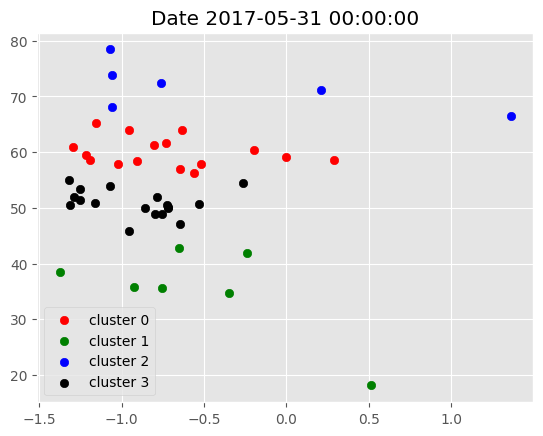

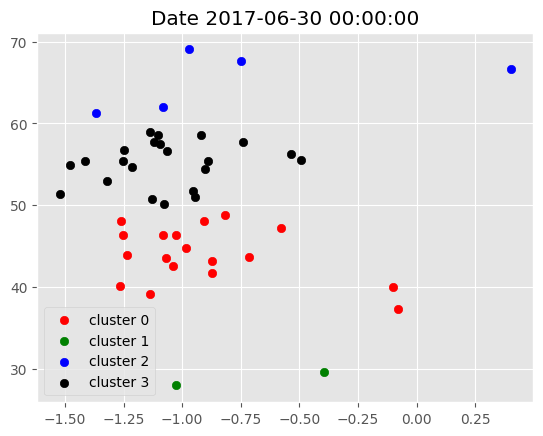

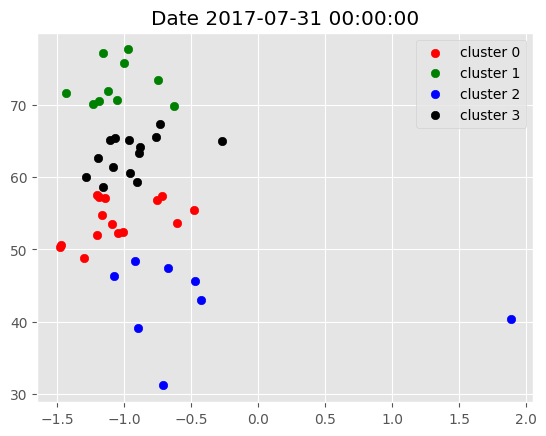

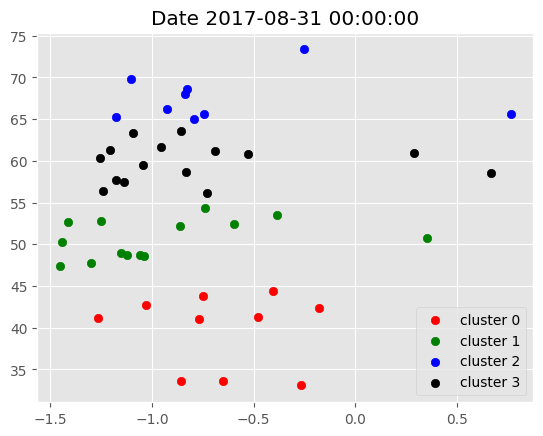

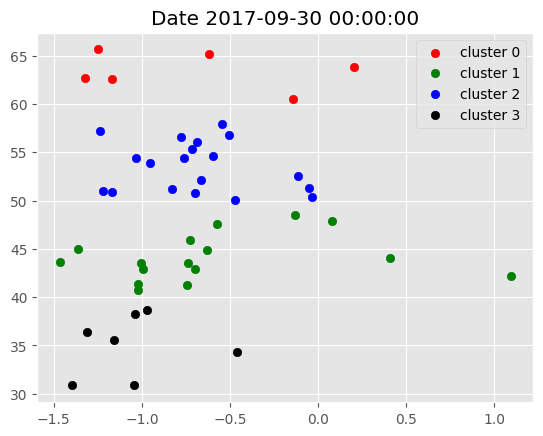

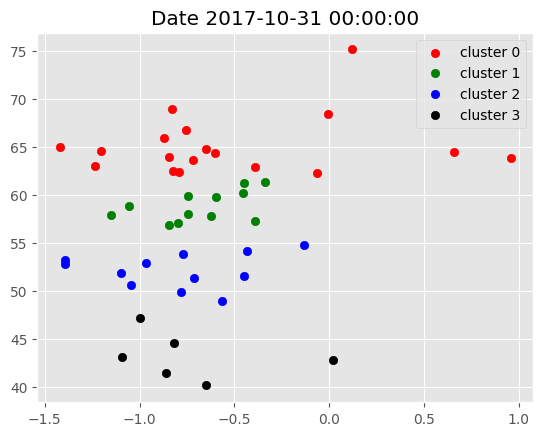

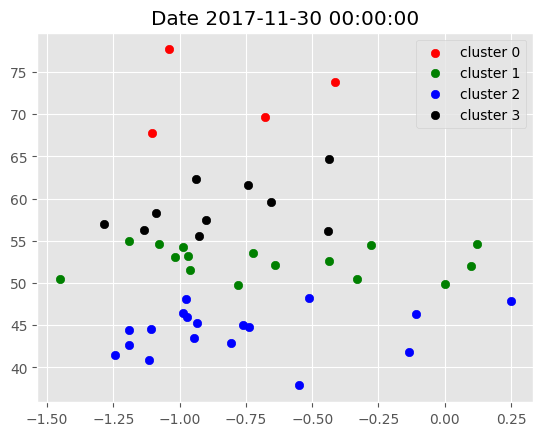

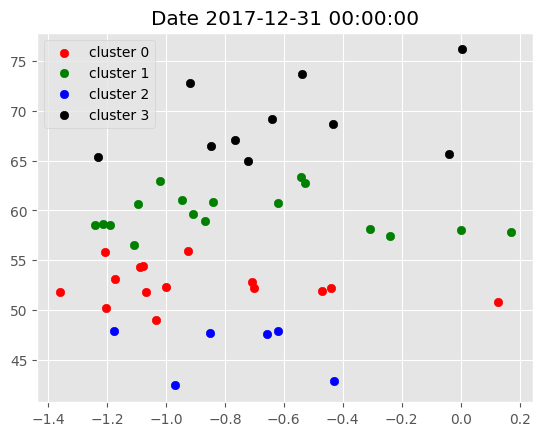

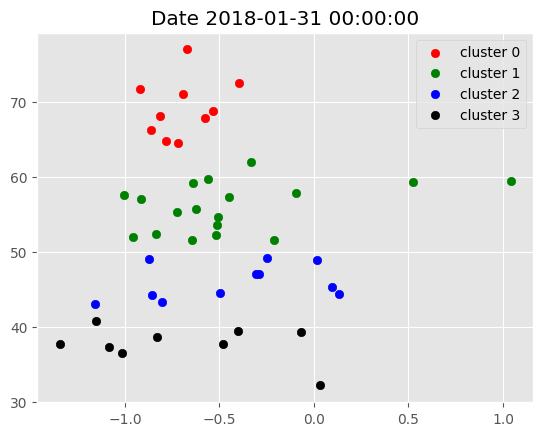

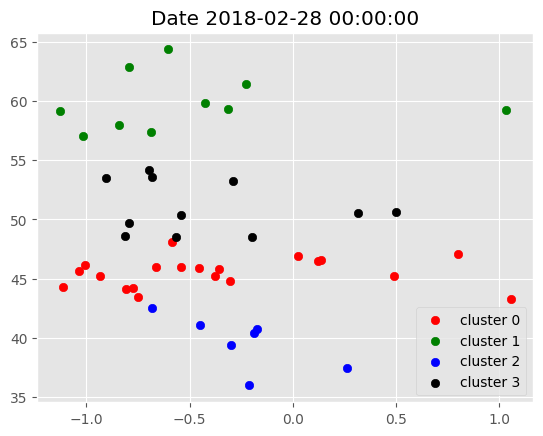

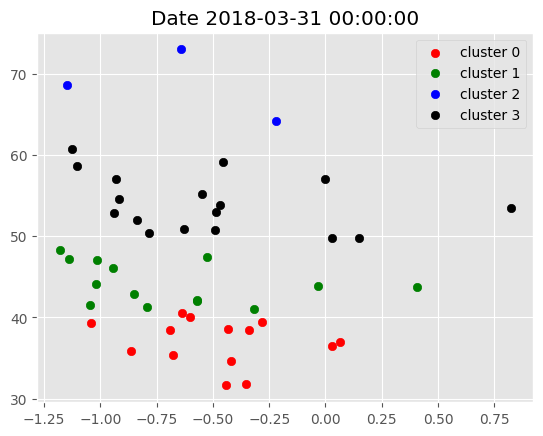

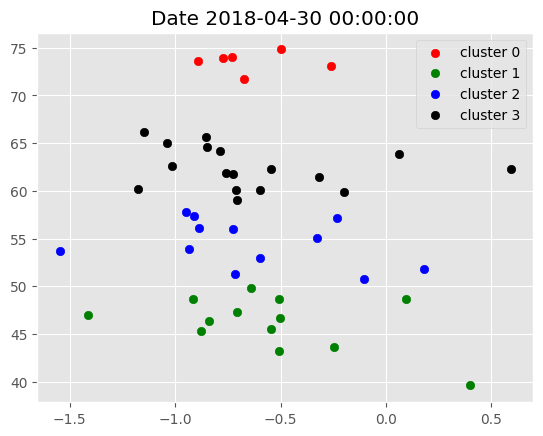

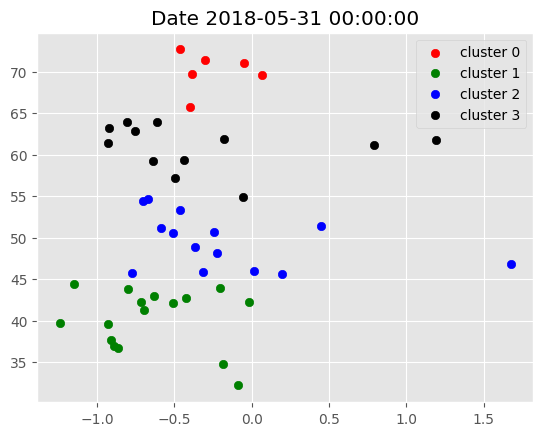

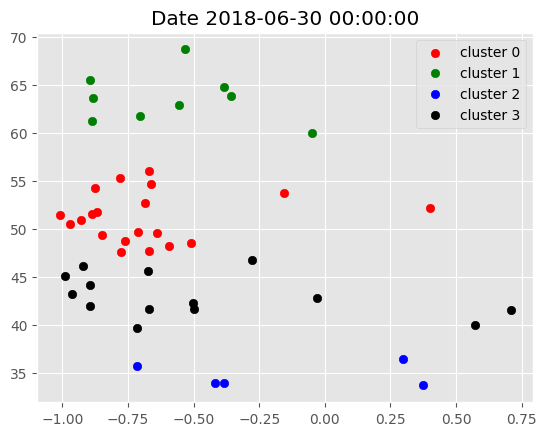

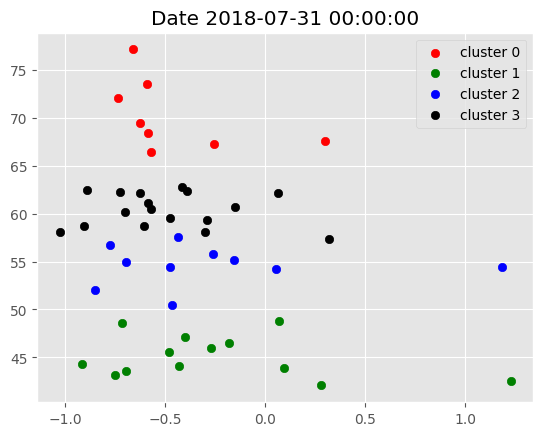

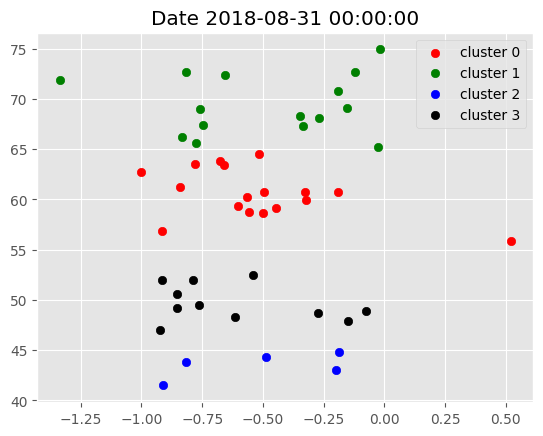

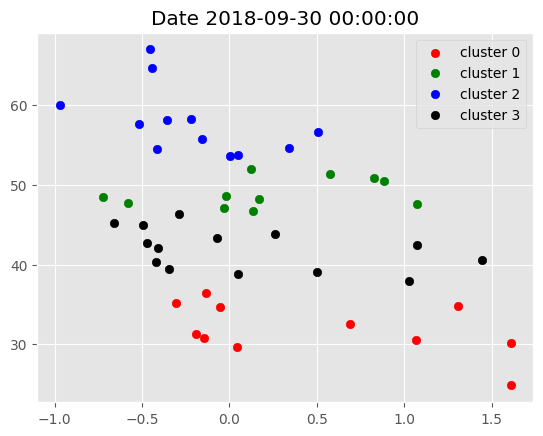

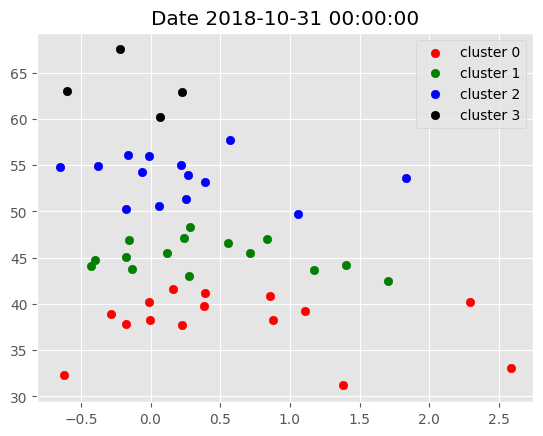

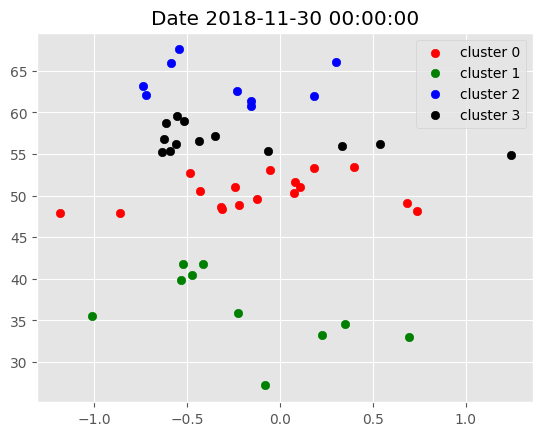

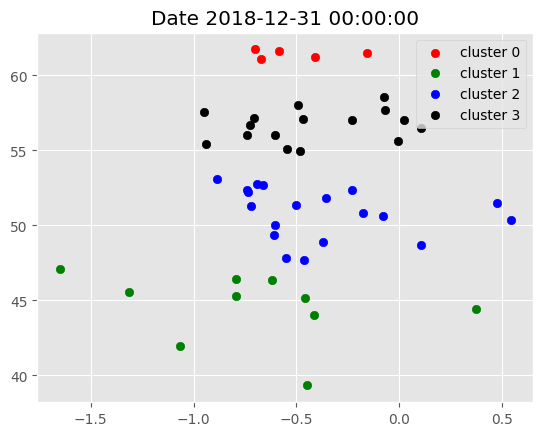

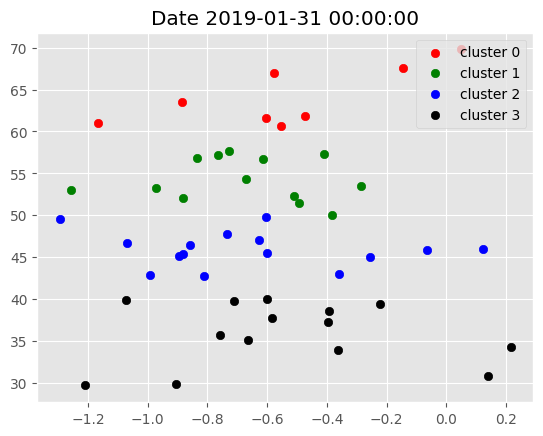

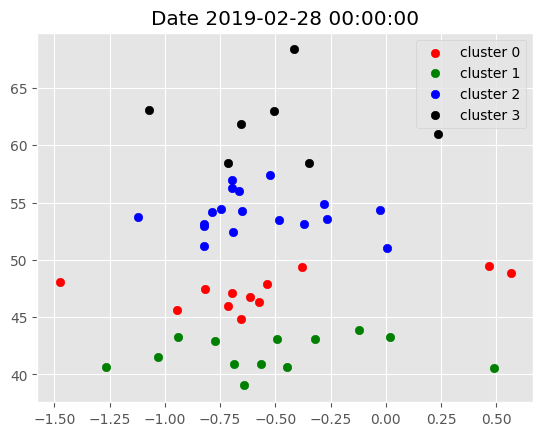

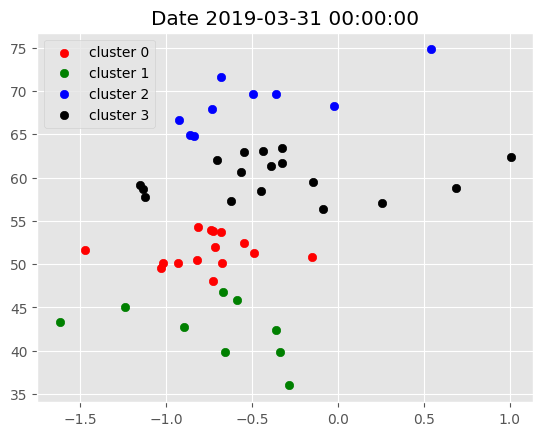

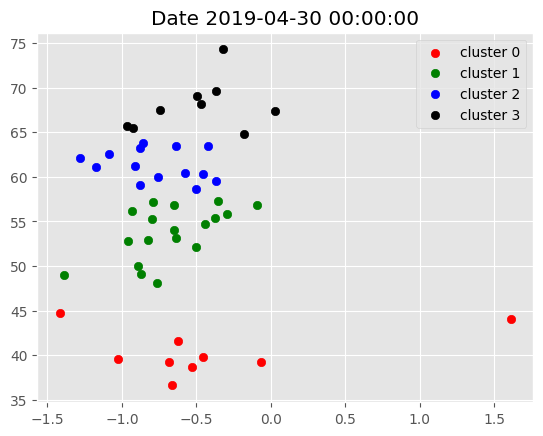

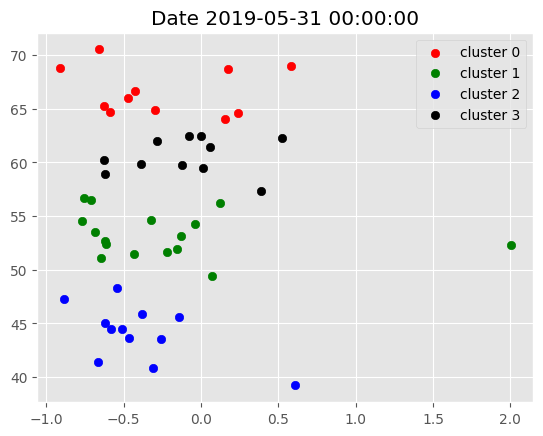

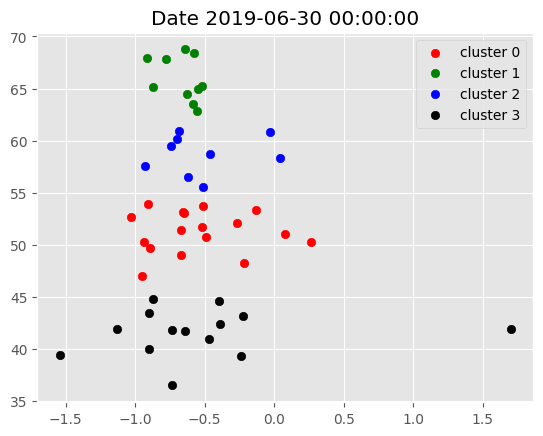

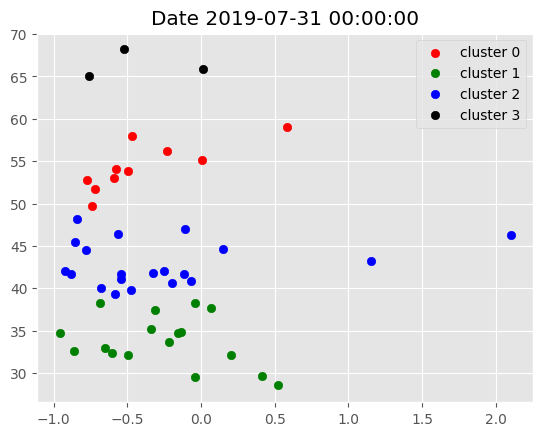

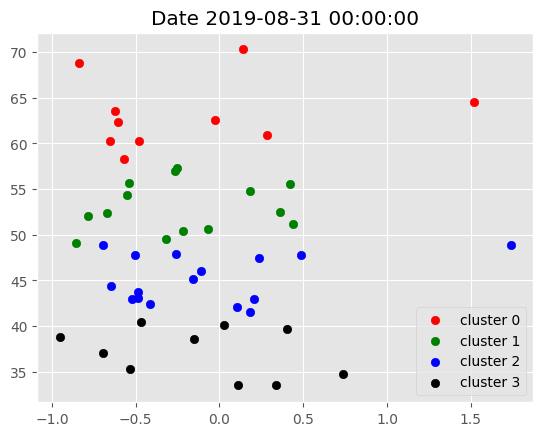

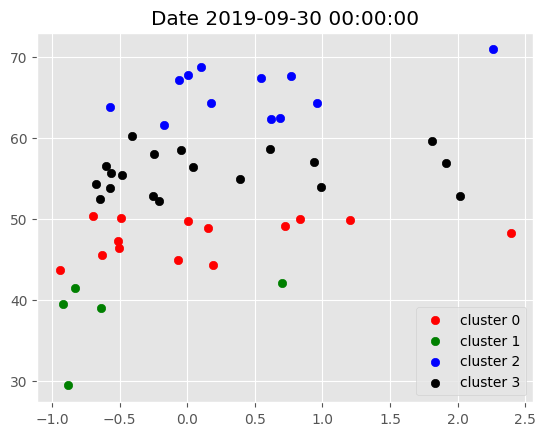

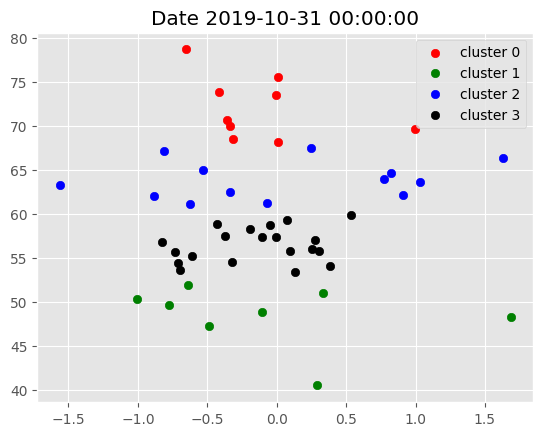

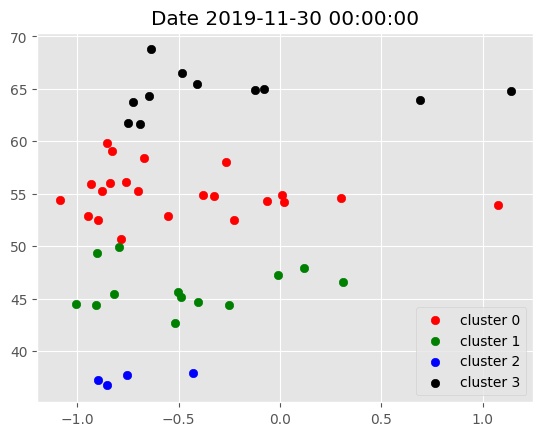

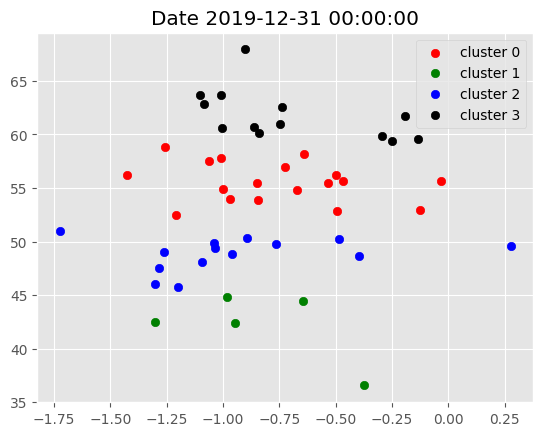

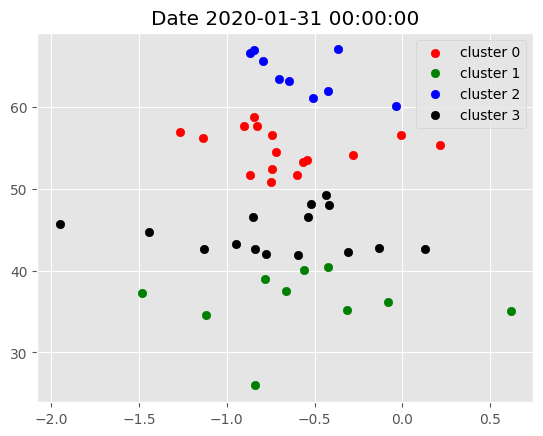

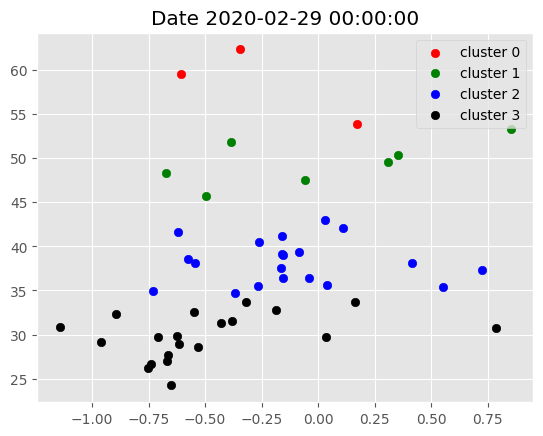

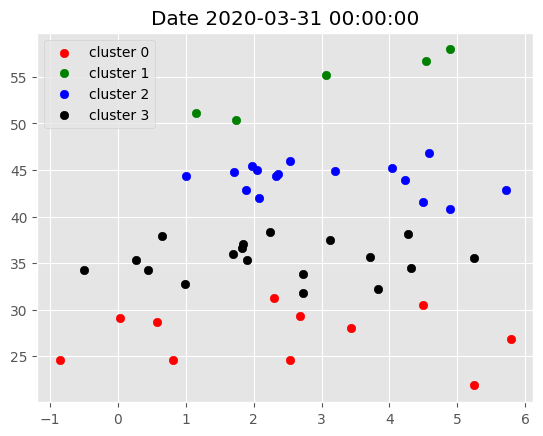

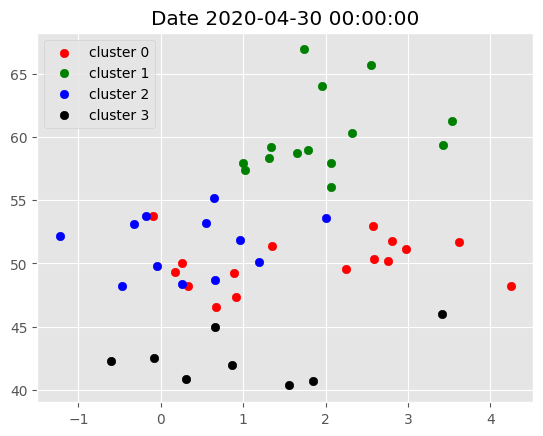

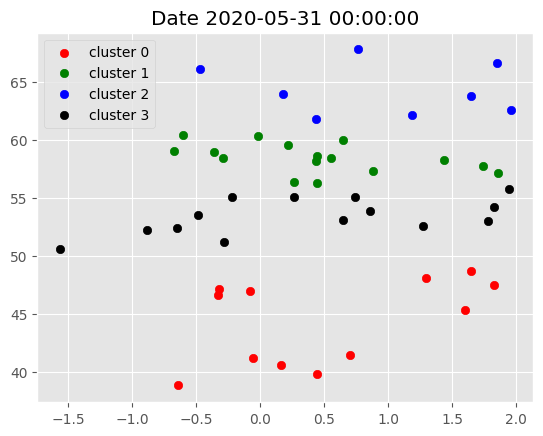

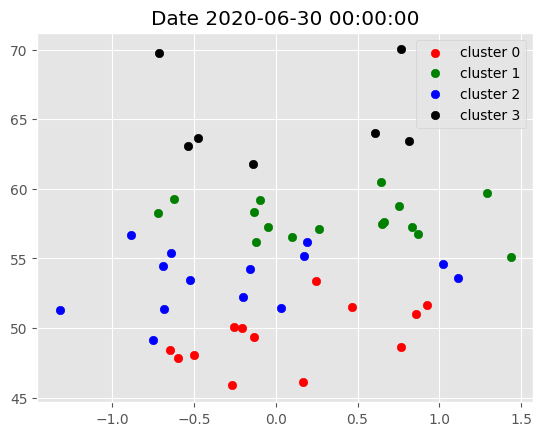

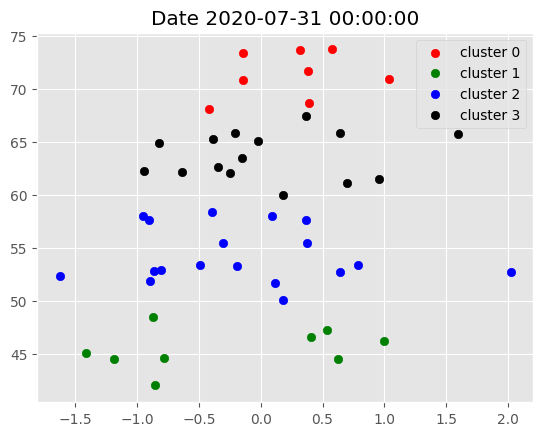

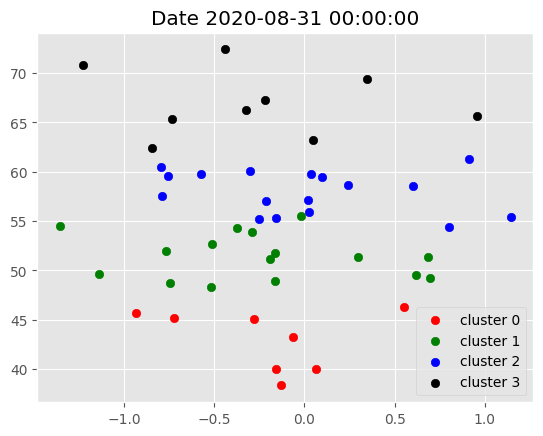

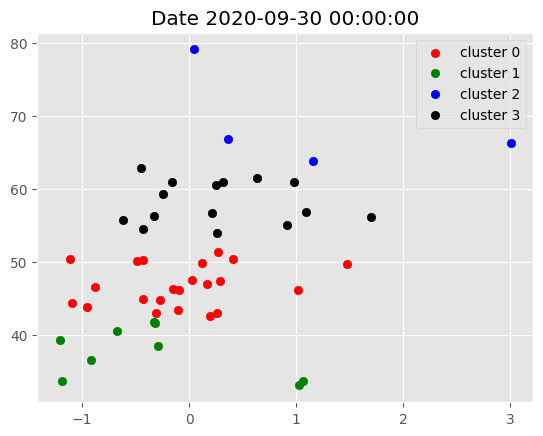

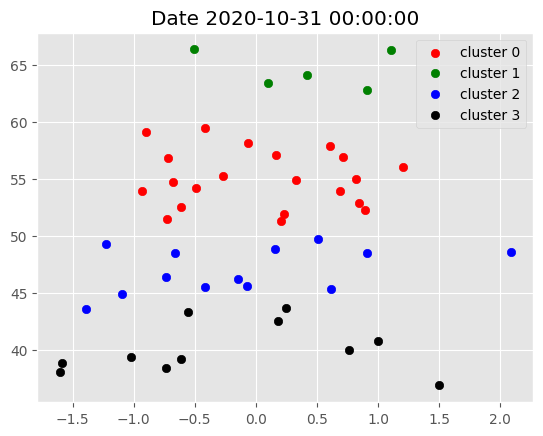

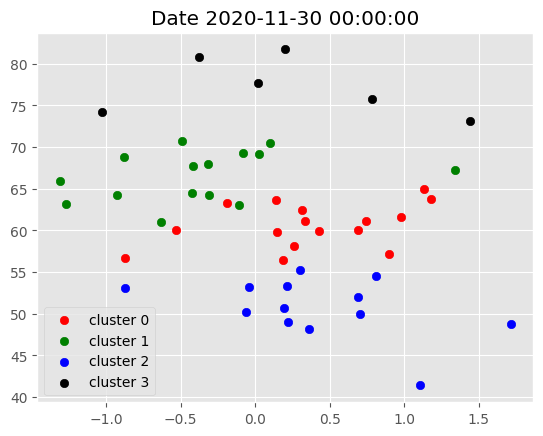

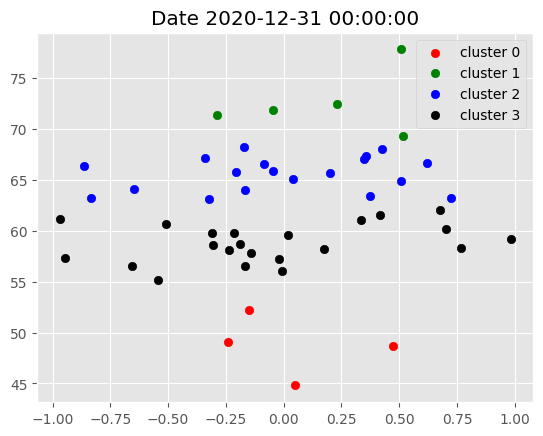

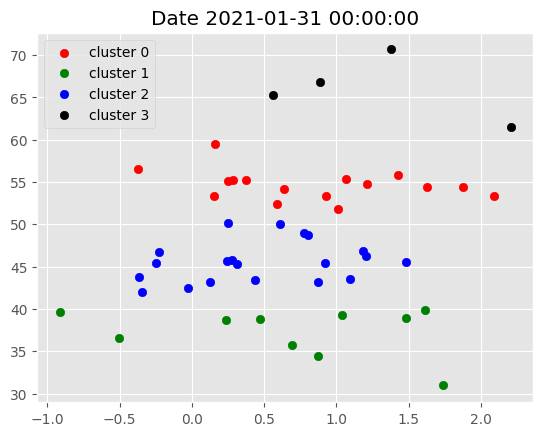

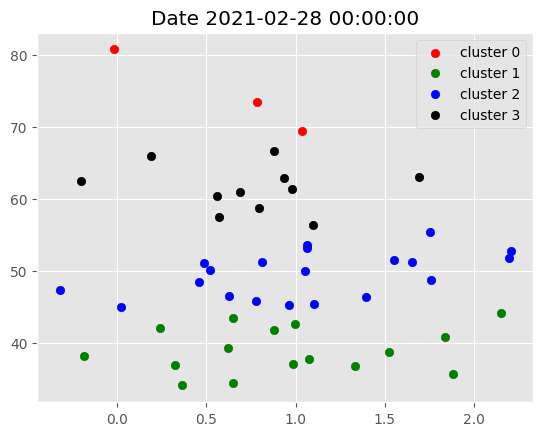

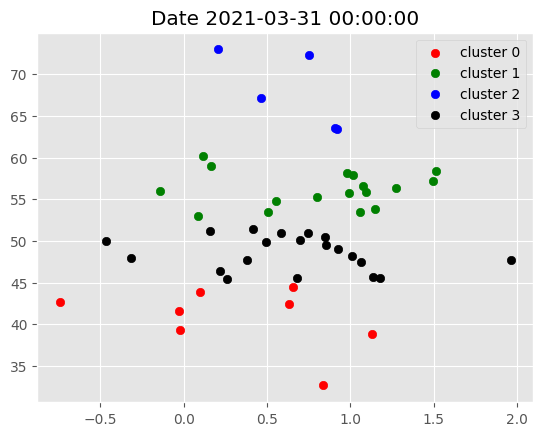

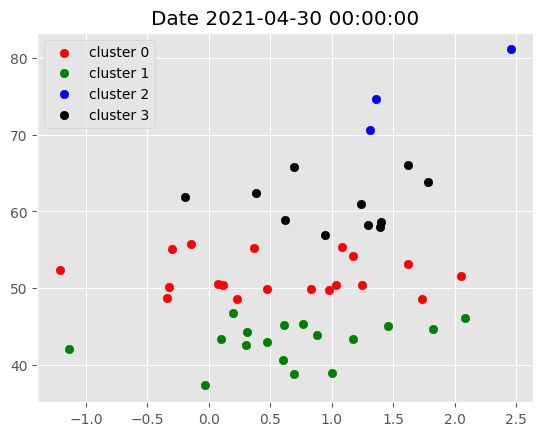

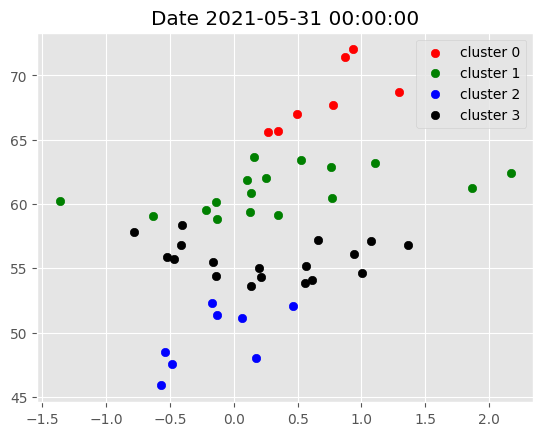

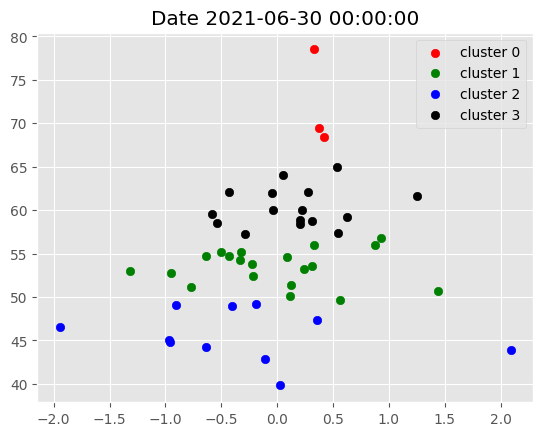

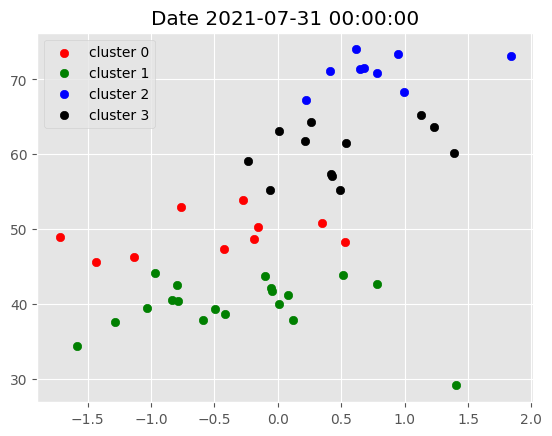

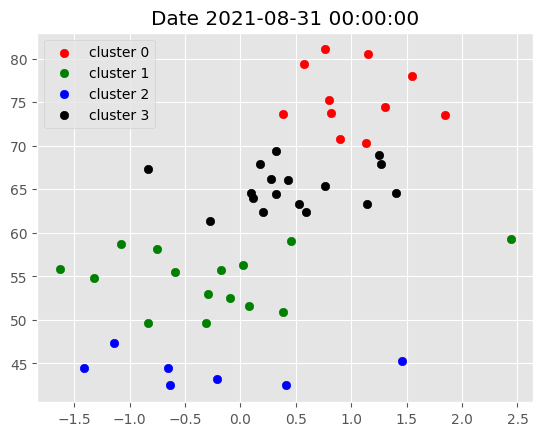

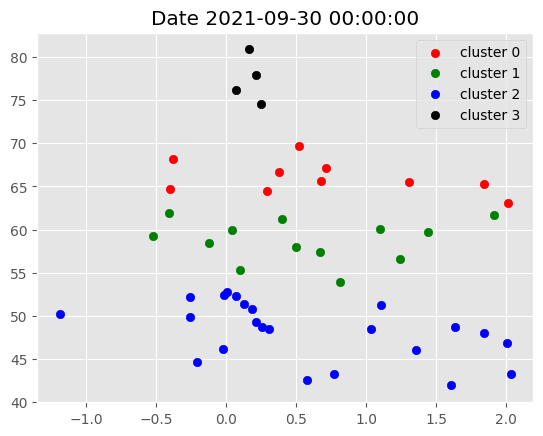

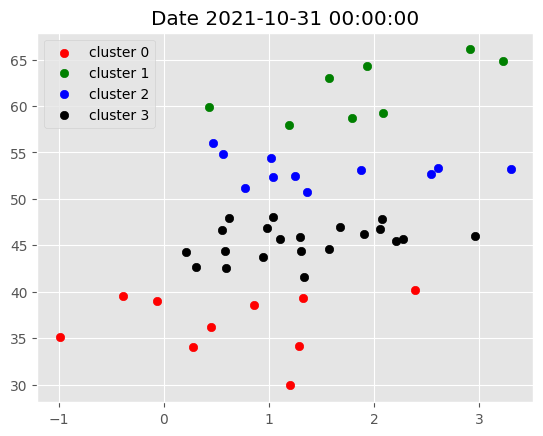

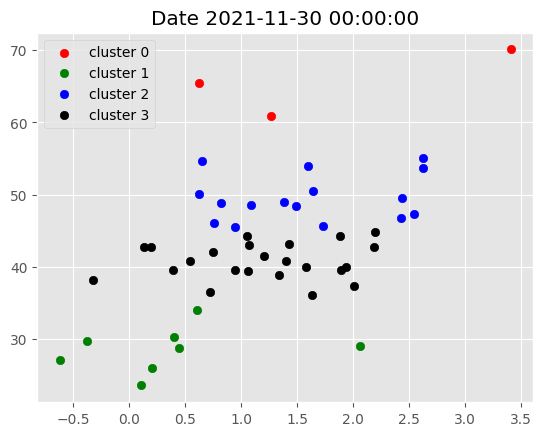

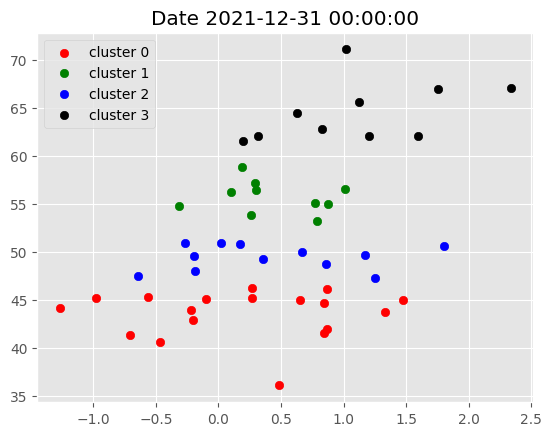

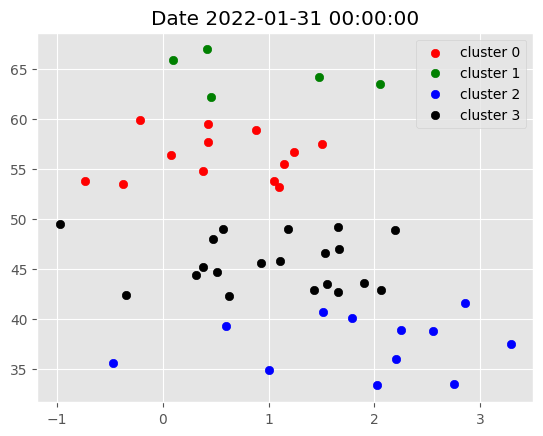

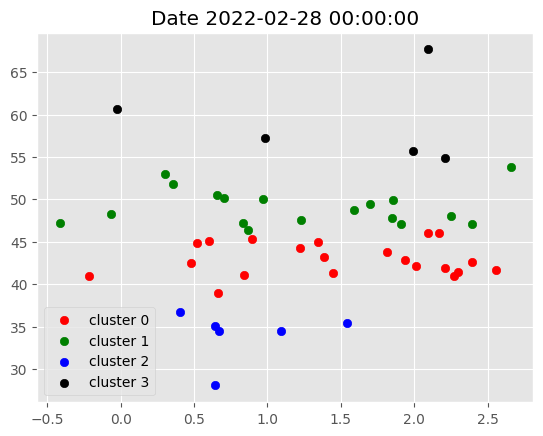

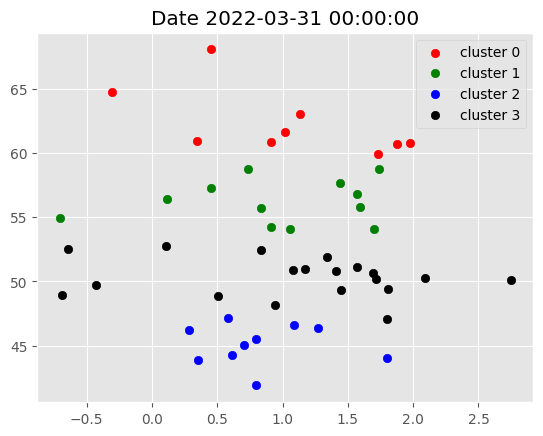

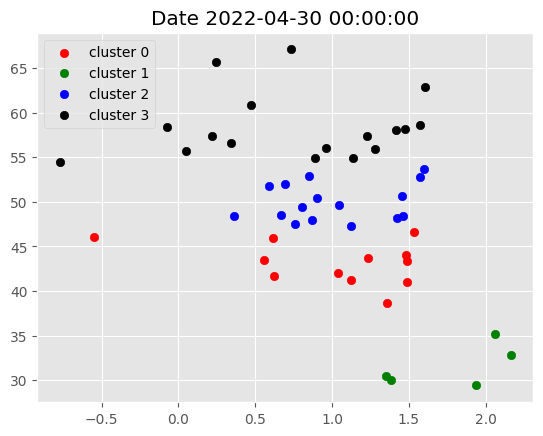

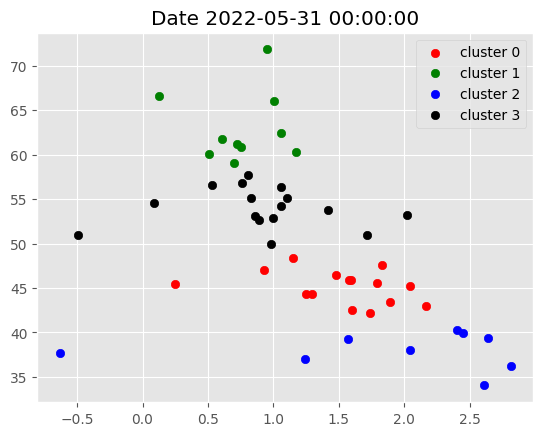

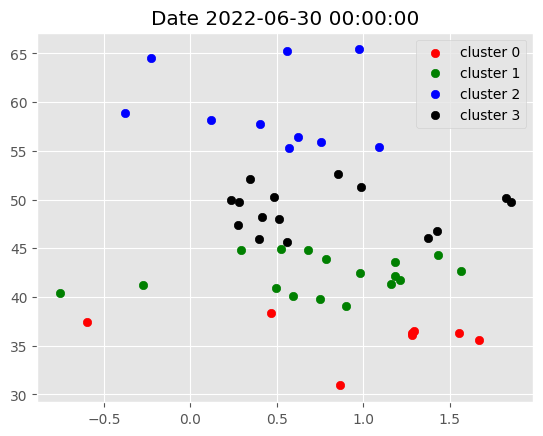

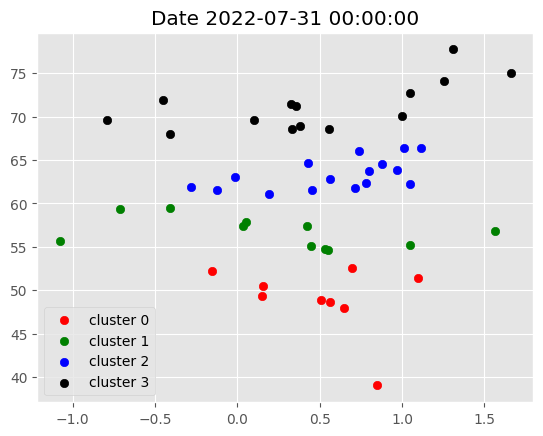

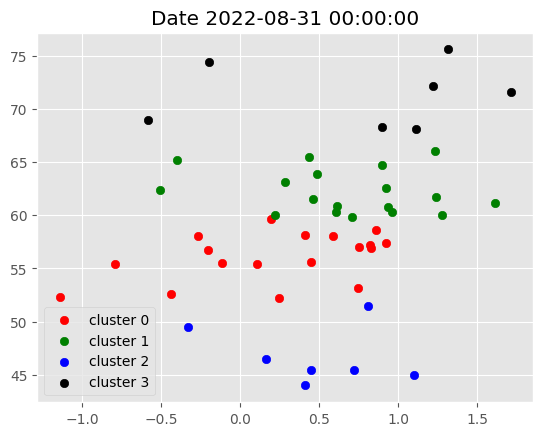

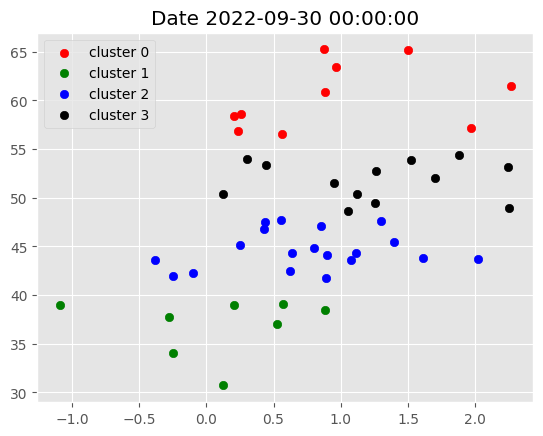

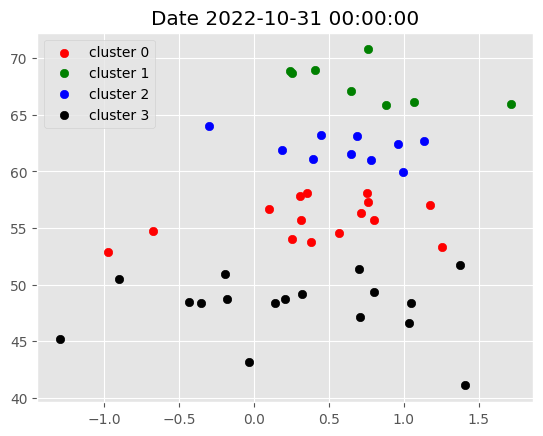

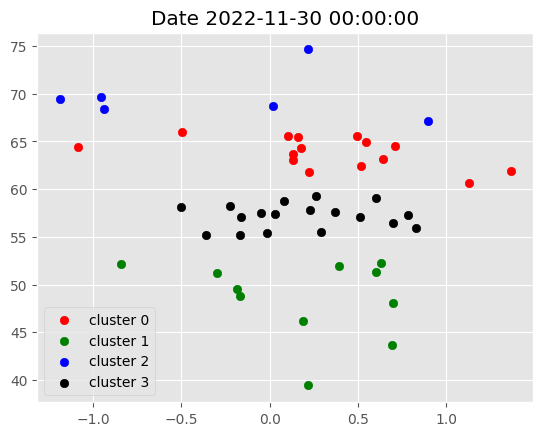

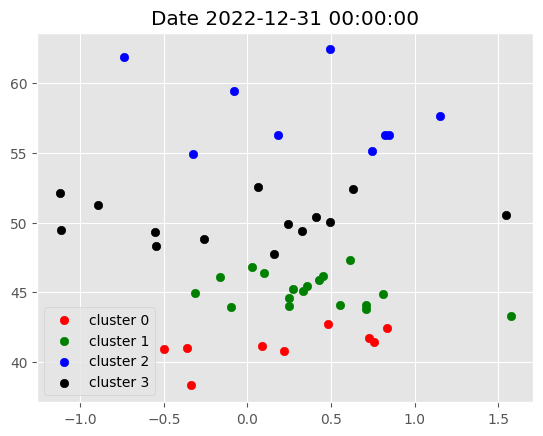

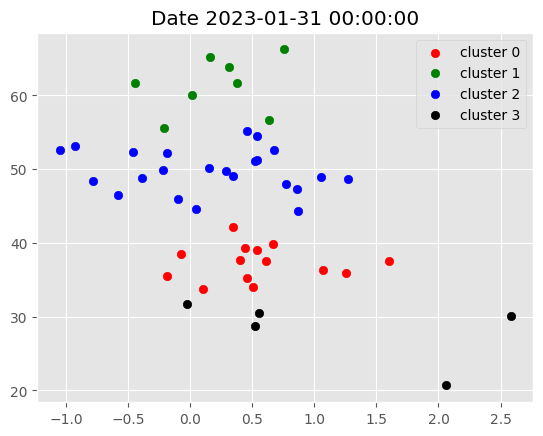

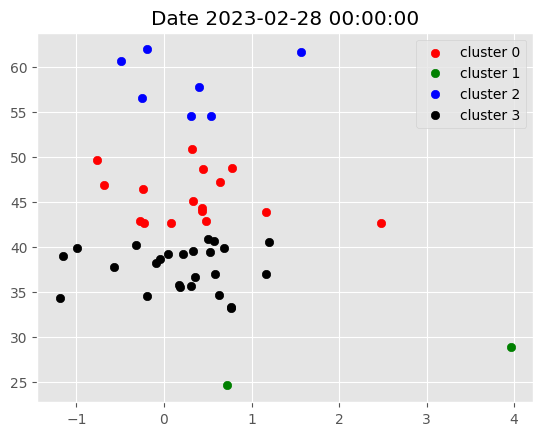

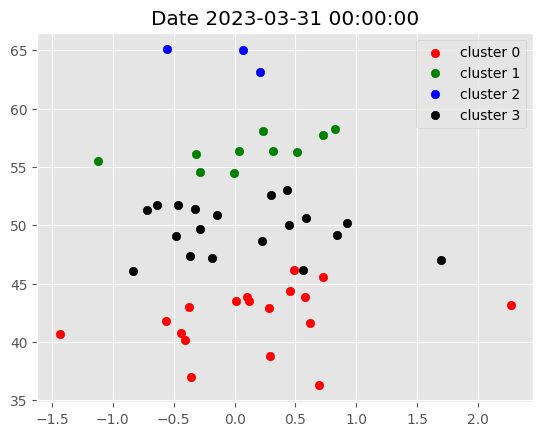

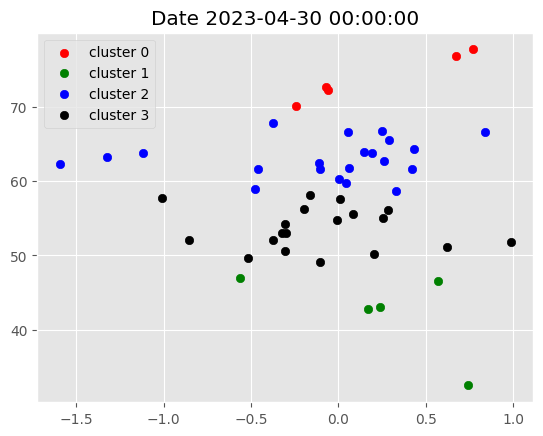

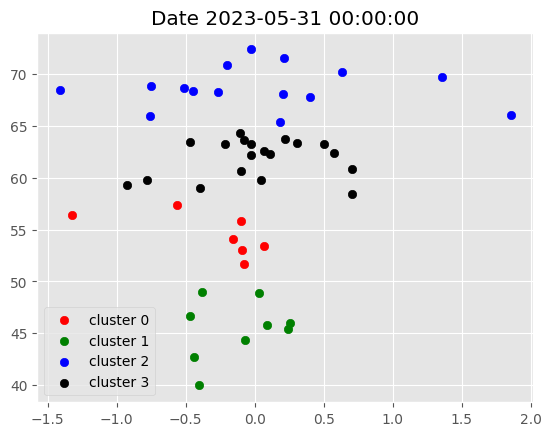

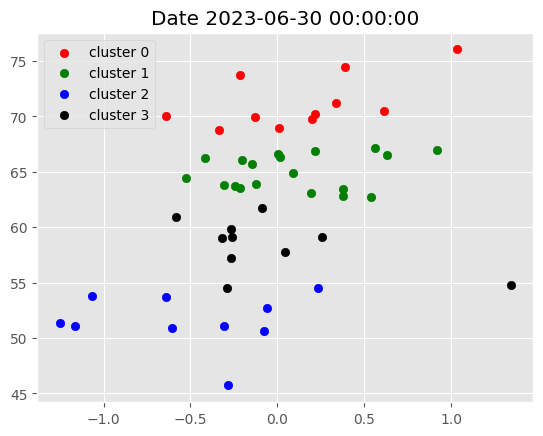

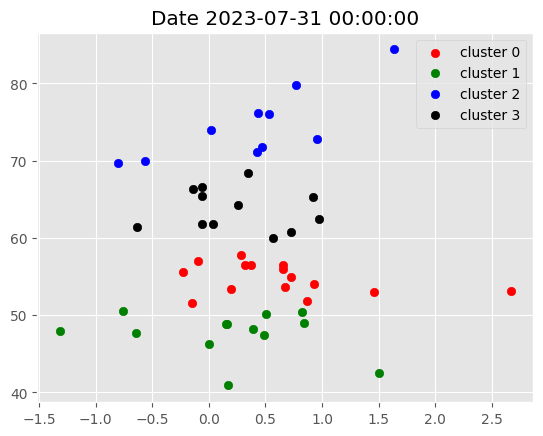

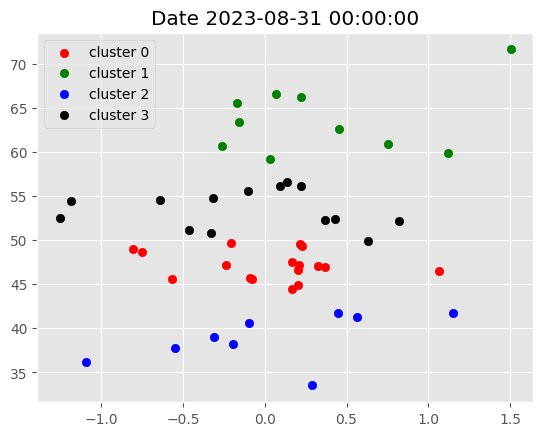

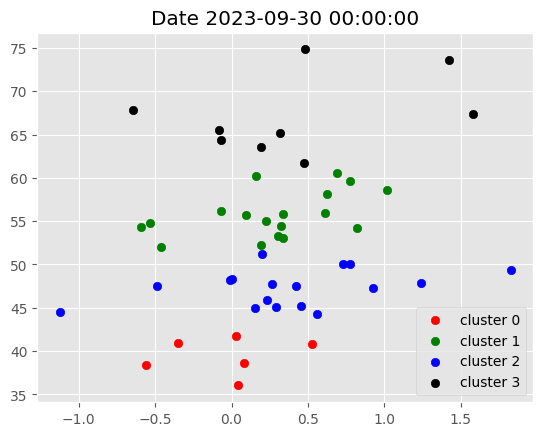

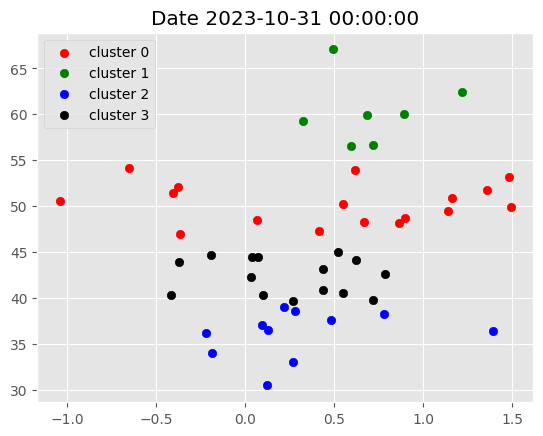

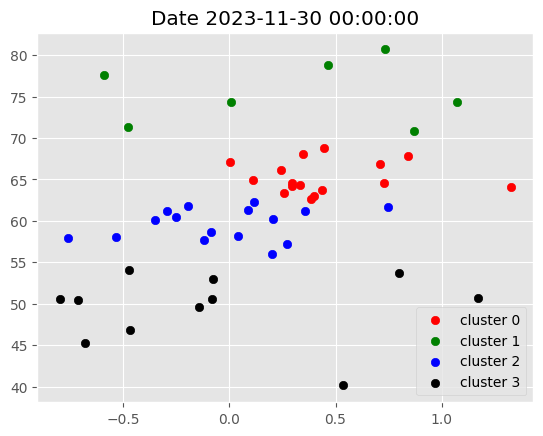

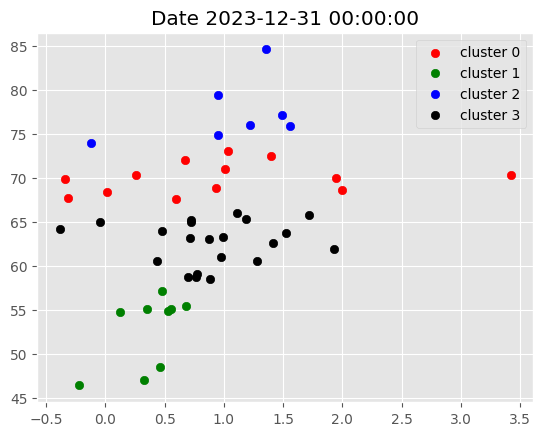

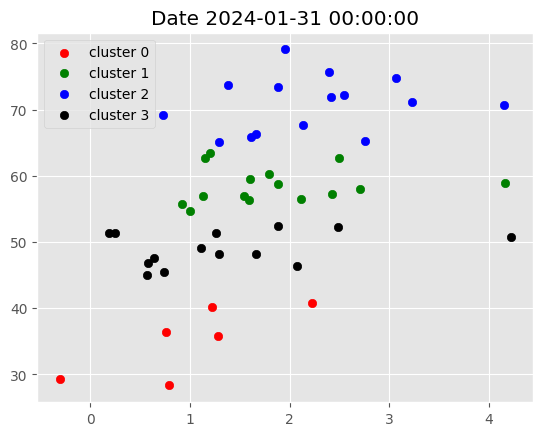

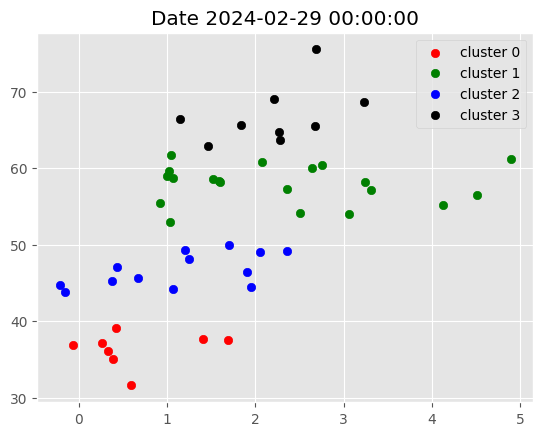

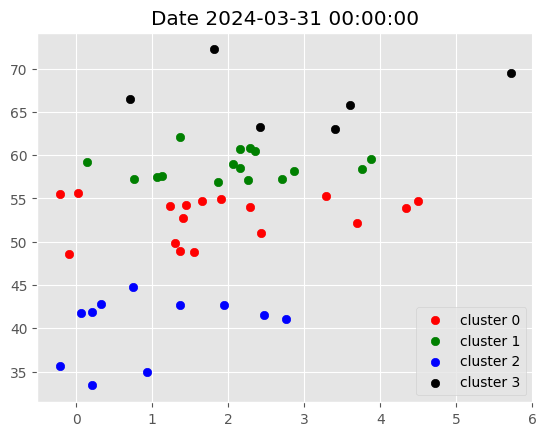

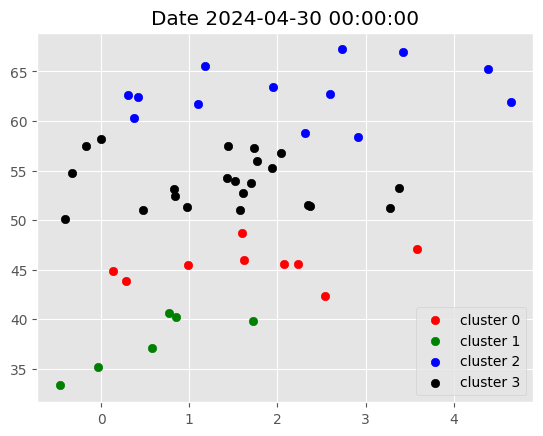

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2017-05-31 ADANIENT.NS   -0.719498  4.219581  4.096614  4.158098   
           ADANIPORTS.NS -0.530420  5.857411  5.760204  5.808808   
           APOLLOHOSP.NS -0.954591  7.172697  7.052727  7.112712   
           ASIANPAINT.NS -0.903931  7.031233  6.954553  6.992893   
           AXISBANK.NS   -1.069351  6.250559  6.185811  6.218185   
...                            ...       ...       ...       ...   
2024-04-30 TCS.NS         1.577376  8.344169  8.238487  8.291328   
           TECHM.NS       0.284990  7.164942  7.118020  7.141481   
           TITAN.NS       2.073647  8.249942  8.175639  8.212791   
           ULTRACEMCO.NS  1.617241  9.217619  9.148792  9.183205   
           WIPRO.NS       0.847070  6.249967  6.138728  6.194348   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-05-31 ADANIENT.NS            0.000725 -0.170783  49.905864   0.072052   
           ADANIPORTS.NS         -0.000518 -0.188829  50.679149   0.034483   
           APOLLOHOSP.NS          0.000214 -0.325411  45.898003  -0.017961   
           ASIANPAINT.NS         -0.000936  0.071482  58.333474   0.027444   
           AXISBANK.NS            0.000010 -0.062394  53.918106   0.008633   
...                                    ...       ...        ...        ...   
2024-04-30 TCS.NS                 0.000123 -0.805206  51.044412   0.032273   
           TECHM.NS               0.000192 -0.632549  43.883352  -0.004807   
           TITAN.NS               0.000130 -0.187154  45.578154  -0.048004   
           ULTRACEMCO.NS          0.000227 -0.220651  45.991351  -0.009909   
           WIPRO.NS               0.000190 -1.198616  40.174997  -0.019475   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-05-31 ADANIENT.NS     0.037305   0.058446   0.094214   0.053932   
           ADANIPORTS.NS  -0.000884   0.039563   0.033678   0.028628   
           APOLLOHOSP.NS   0.019528  -0.023748   0.002191  -0.011987   
           ASIANPAINT.NS   0.035558   0.039733   0.028973  -0.000369   
           AXISBANK.NS     0.023412   0.004845   0.015097  -0.016457   
...                             ...        ...        ...        ...   
2024-04-30 TCS.NS         -0.011507   0.015944   0.029892   0.018365   
           TECHM.NS       -0.012541  -0.023427   0.017234   0.013223   
           TITAN.NS       -0.000704  -0.007105   0.021285   0.020918   
           ULTRACEMCO.NS  -0.012197  -0.017171   0.022984   0.016669   
           WIPRO.NS       -0.047250  -0.005186   0.035889   0.017083   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2017-05-31 ADANIENT.NS      0.040122  0.357644 -0.431359  0.232805  1.792711   
           ADANIPORTS.NS    0.048447  0.238526  0.179377  0.458822  0.424557   
           APOLLOHOSP.NS   -0.010167  0.388318 -0.402198  0.216245 -0.223648   
           ASIANPAINT.NS    0.013750  0.118724  0.192662  0.184720  0.430719   
           AXISBANK.NS      0.000590  0.831174  0.213044  0.428031 -0.391474   
...                              ...       ...       ...       ...       ...   
2024-04-30 TCS.NS           0.019752  0.426292  0.064420 -0.099203 -0.143676   
           TECHM.NS         0.019349  0.699532 -0.471853  0.299109 -0.430419   
           TITAN.NS         0.026857  0.370447  0.187161  0.314551  0.659640   
           ULTRACEMCO.NS    0.021002  0.360844 -0.101697  0.680892  0.245724   
           WIPRO.NS         0.017079  0.492931 -0.278554  0.277587 -0.088338   

                               CMA  cluster  
date       ticker                            
2017-05-31 ADANIENT.NS   -0.434594        1  
           ADAN

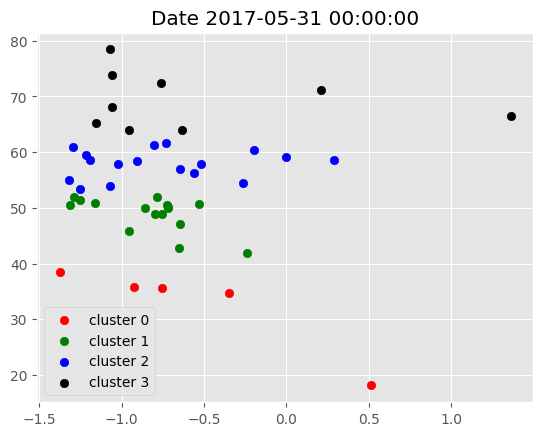

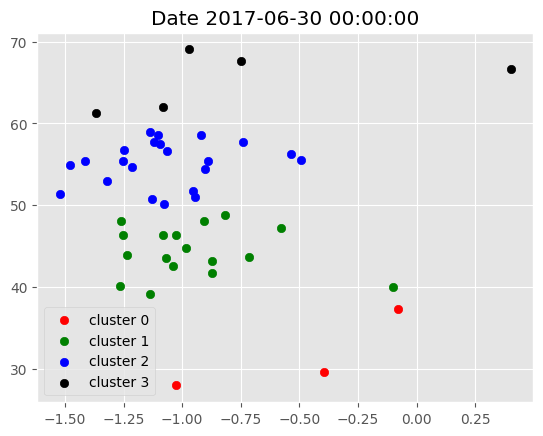

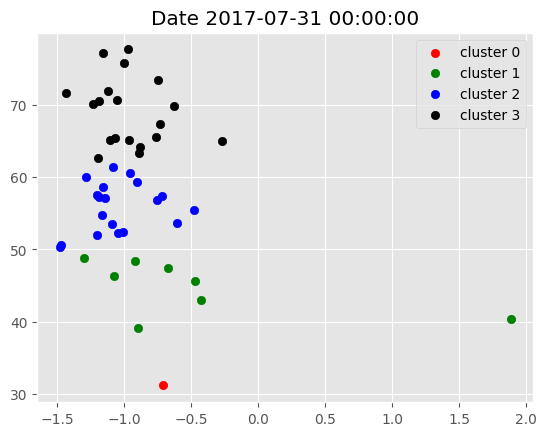

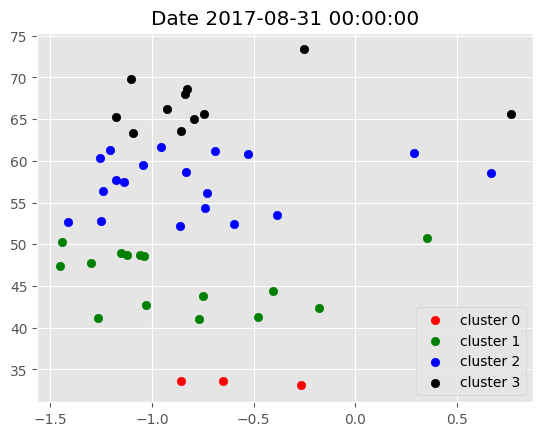

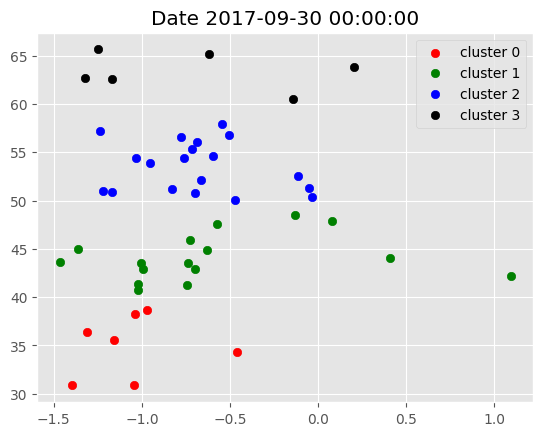

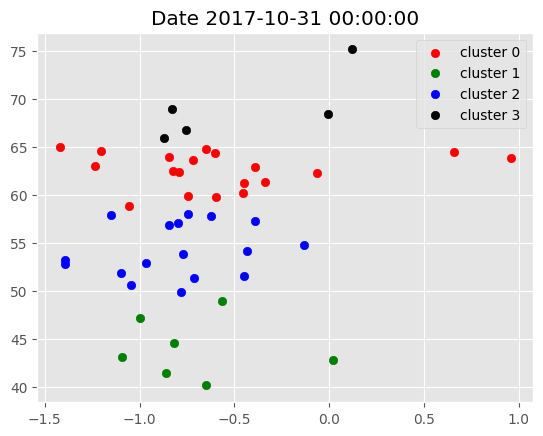

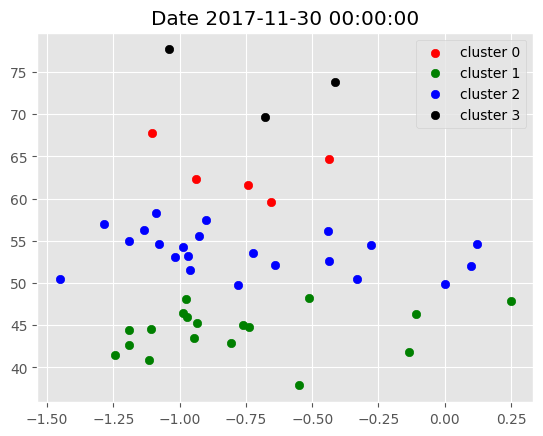

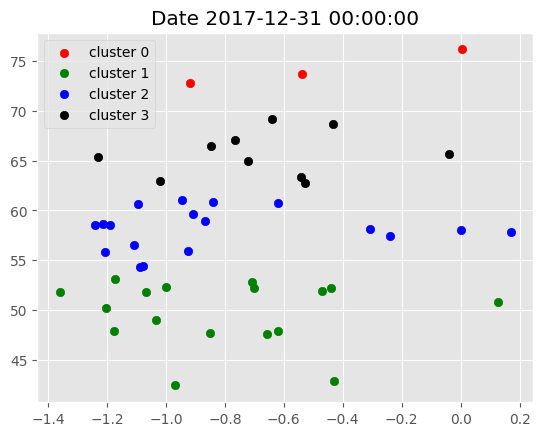

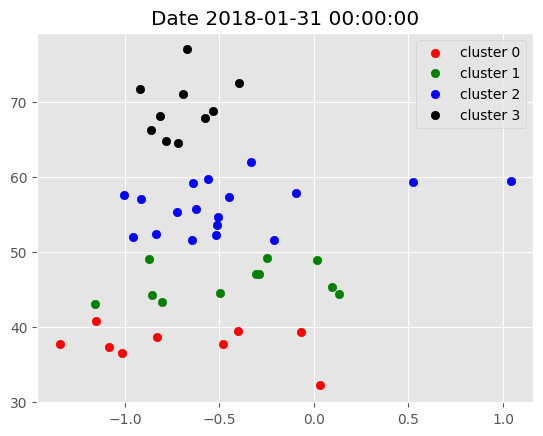

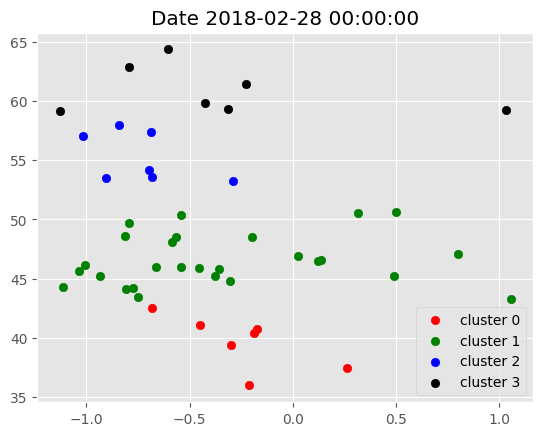

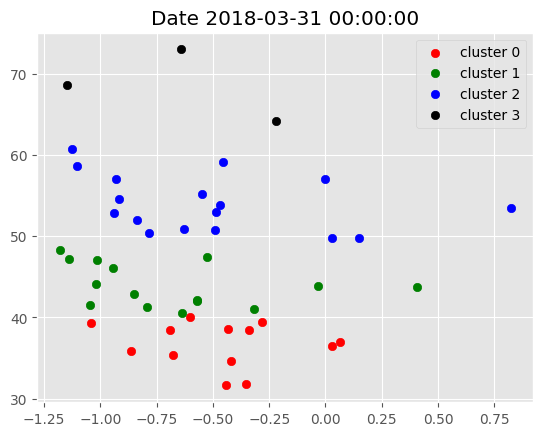

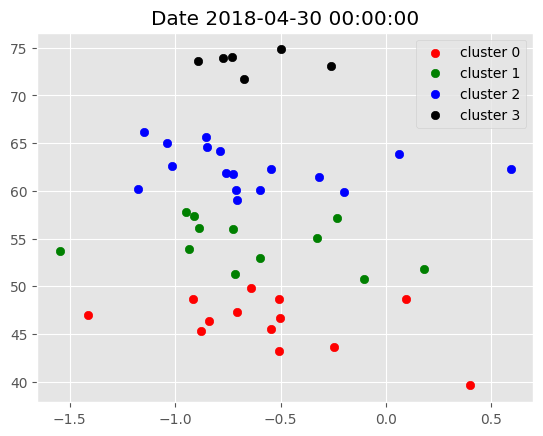

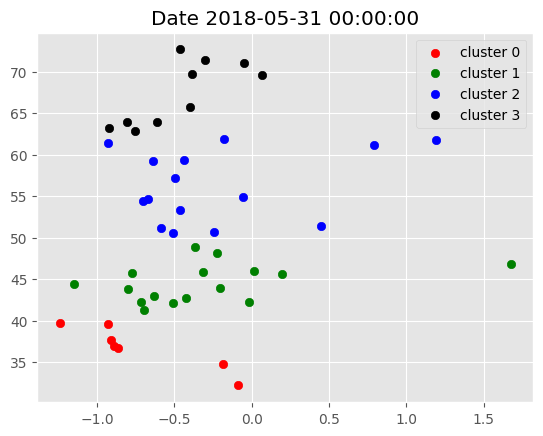

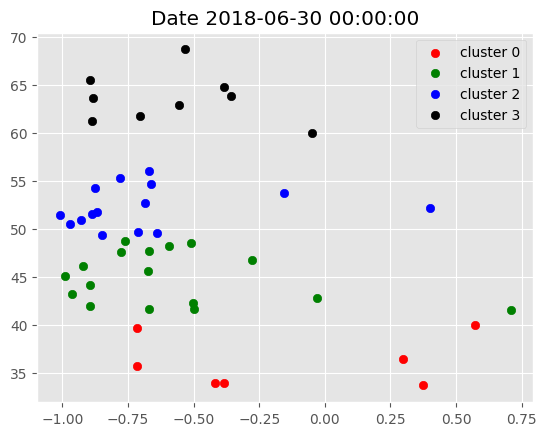

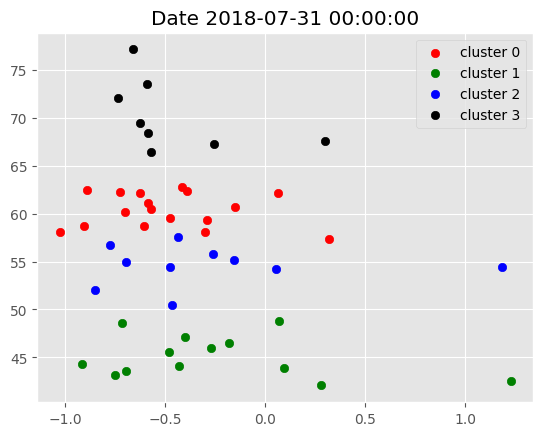

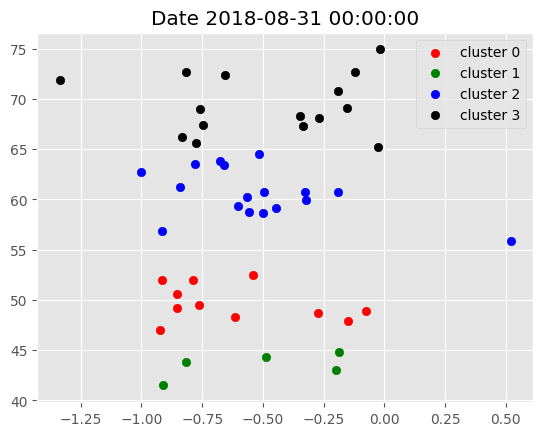

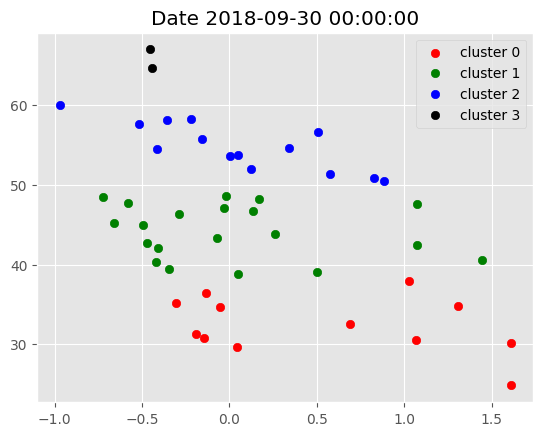

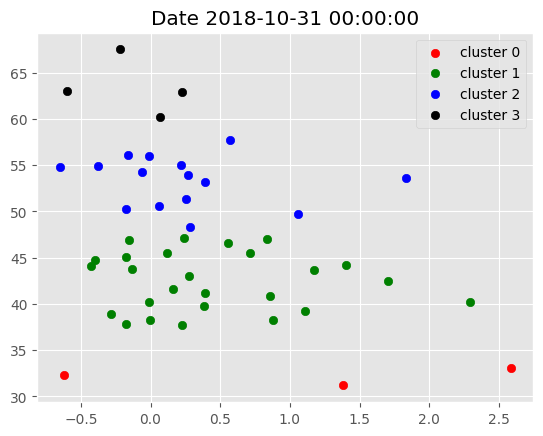

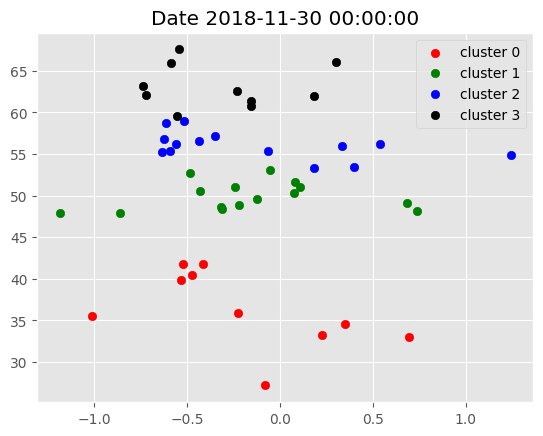

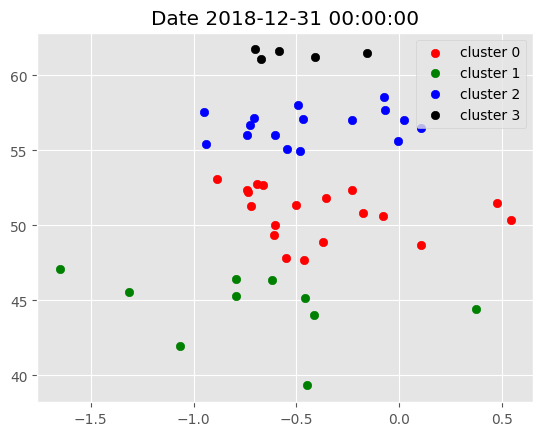

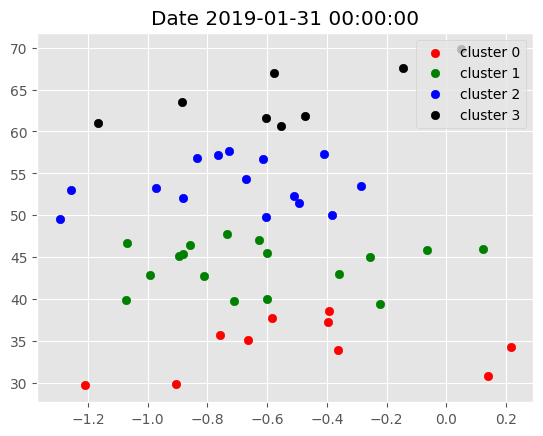

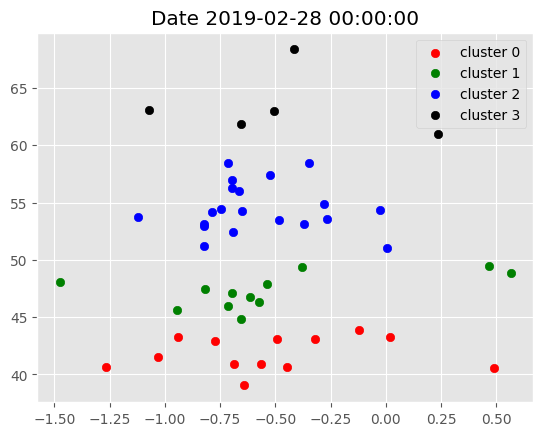

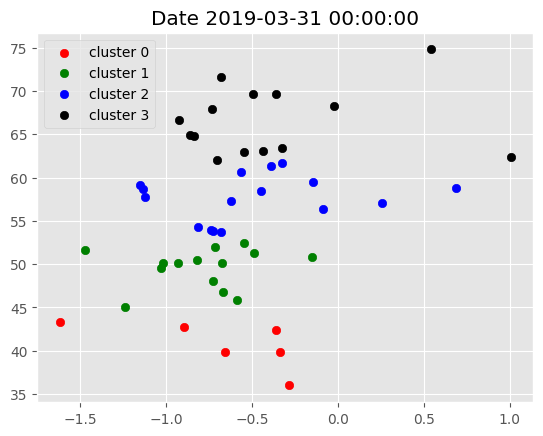

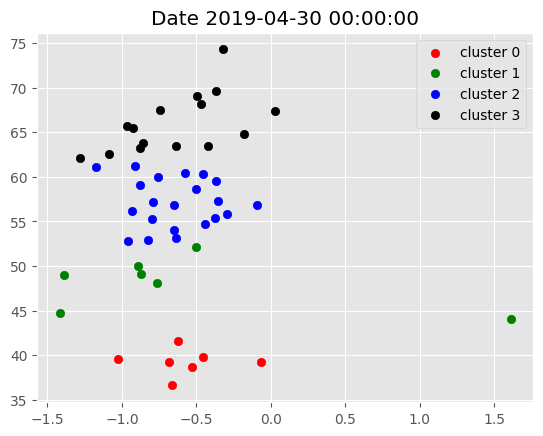

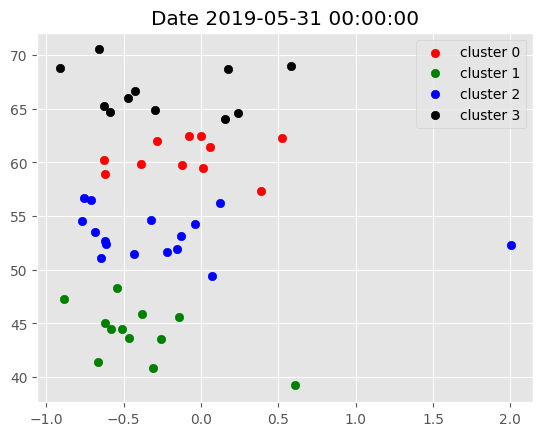

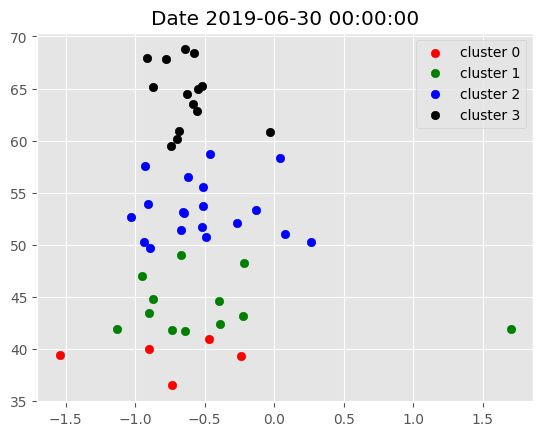

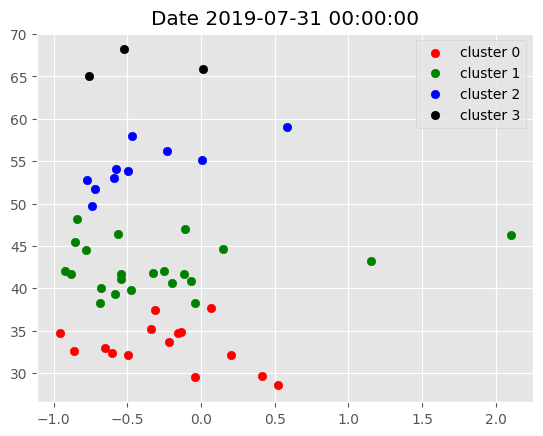

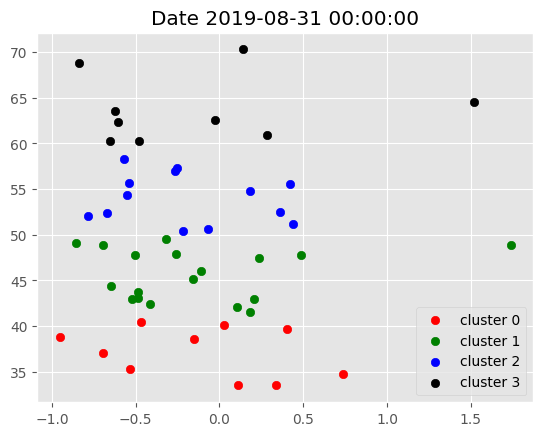

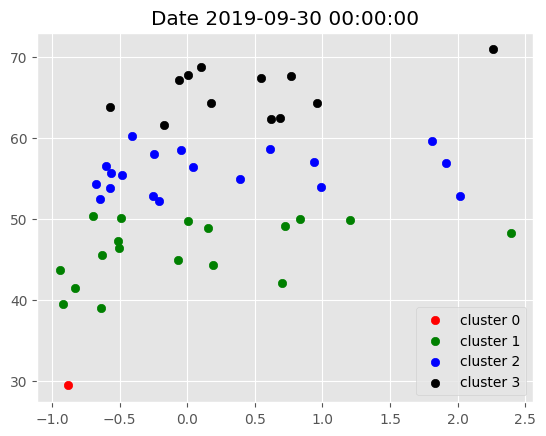

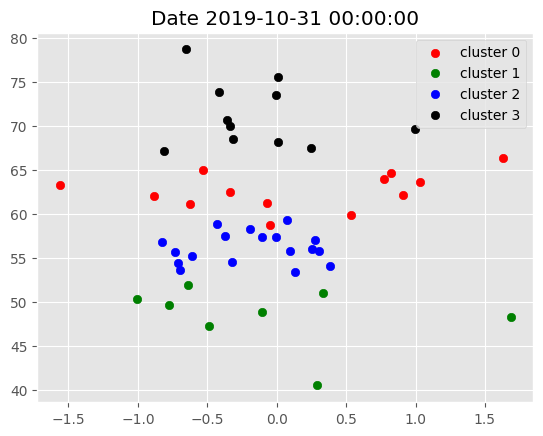

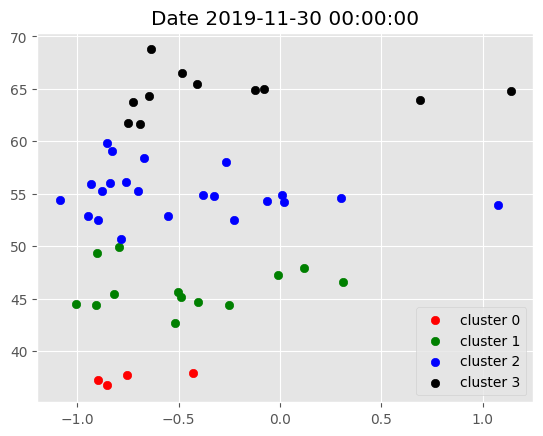

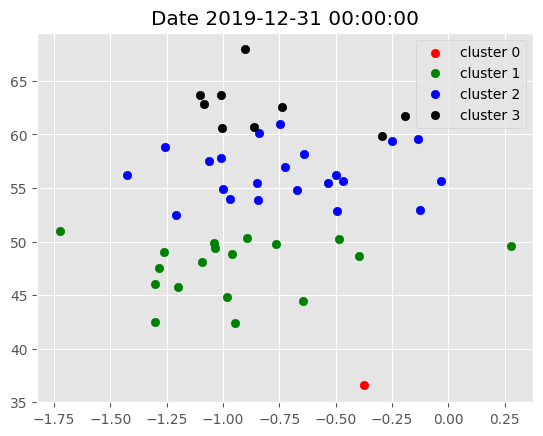

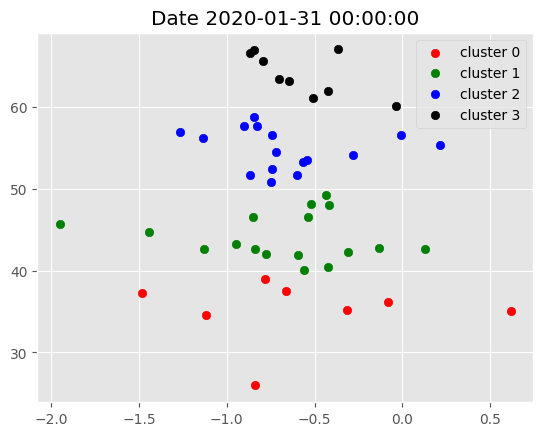

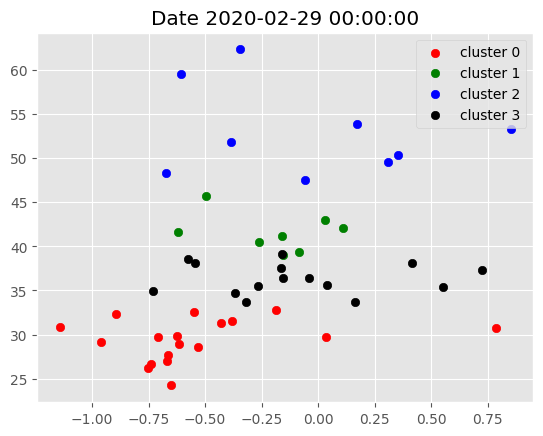

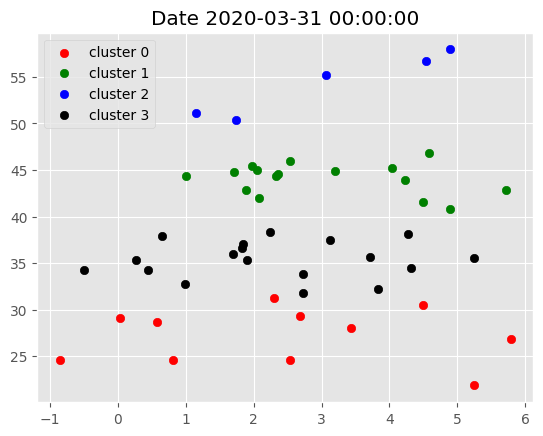

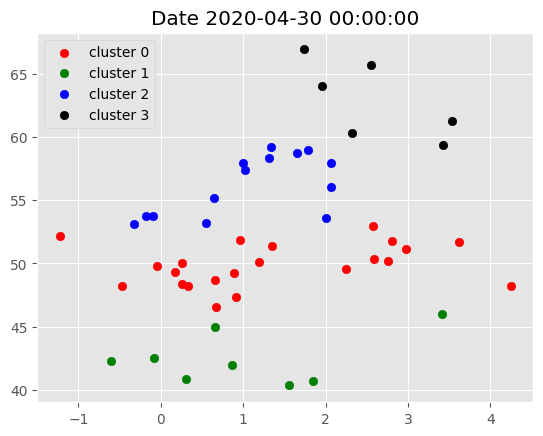

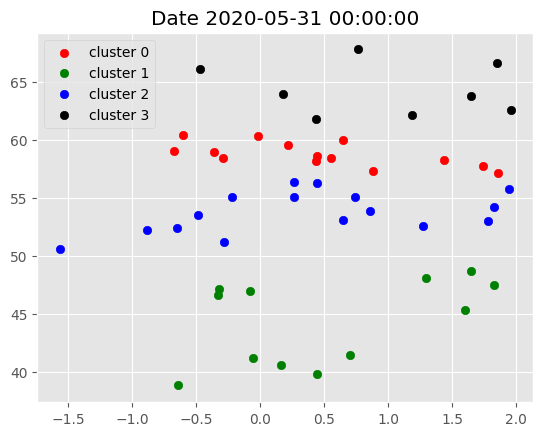

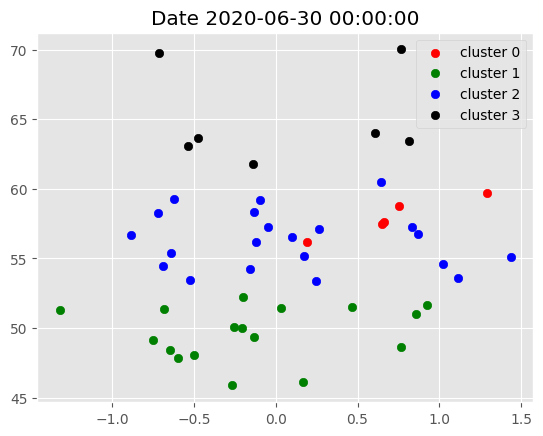

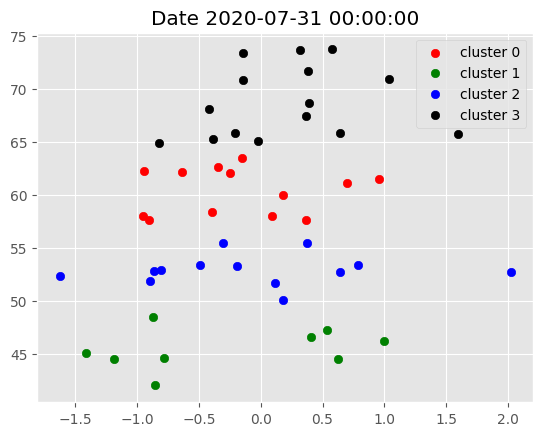

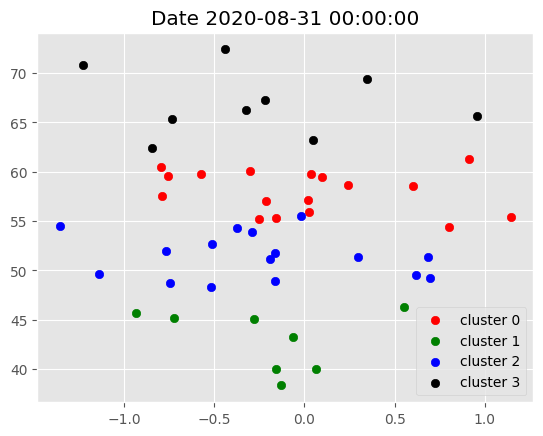

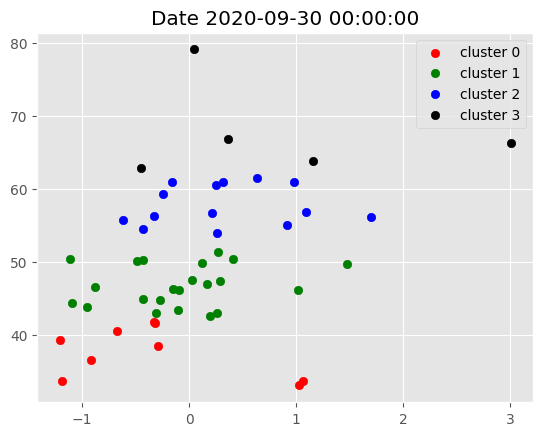

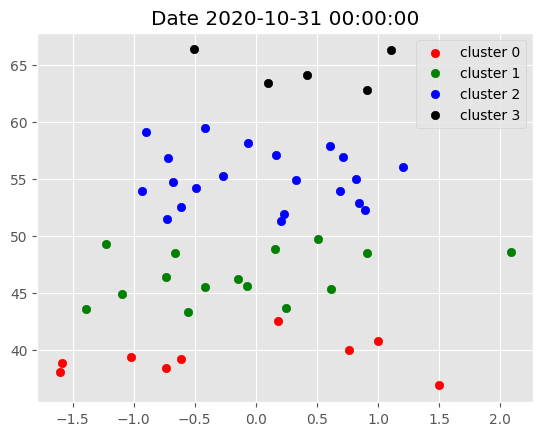

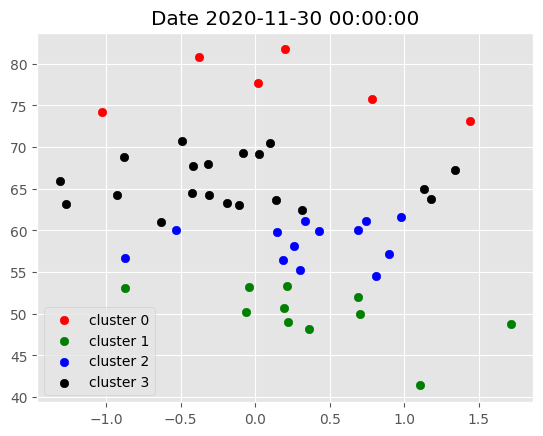

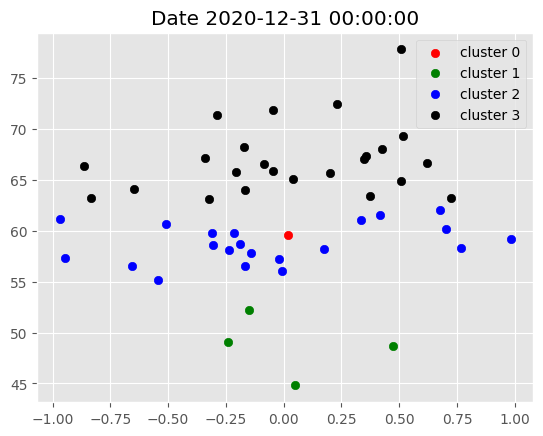

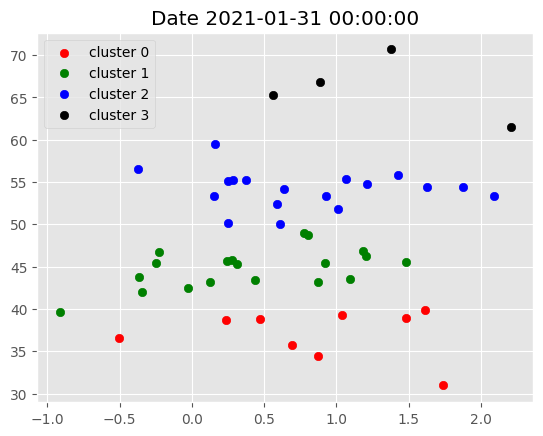

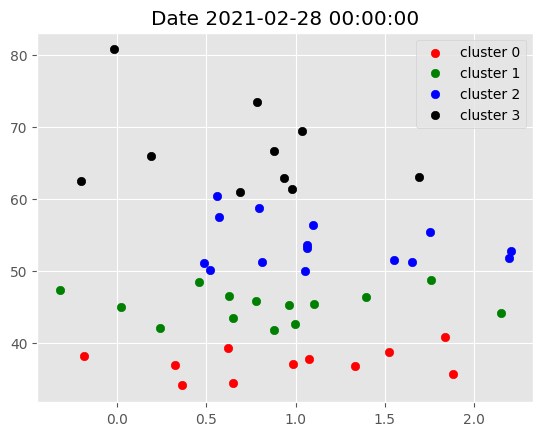

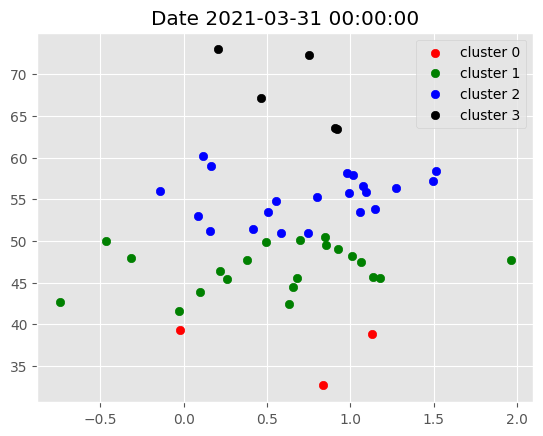

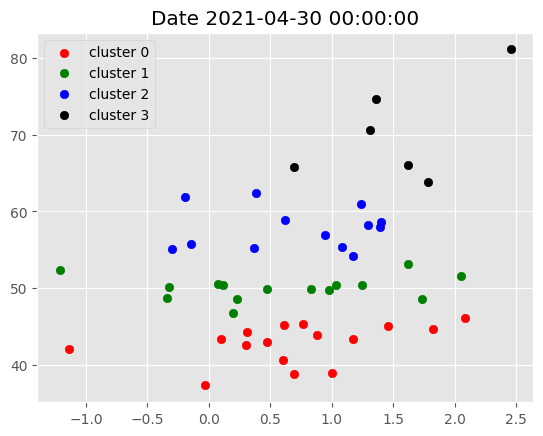

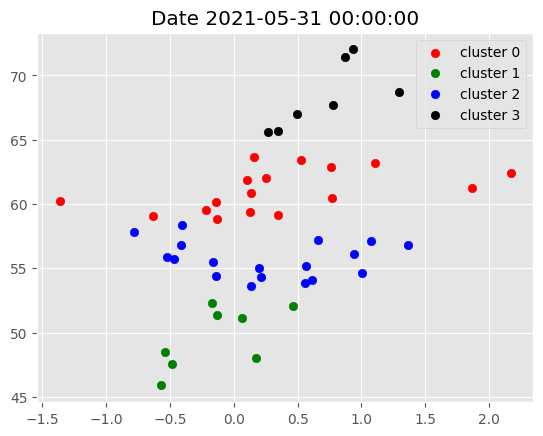

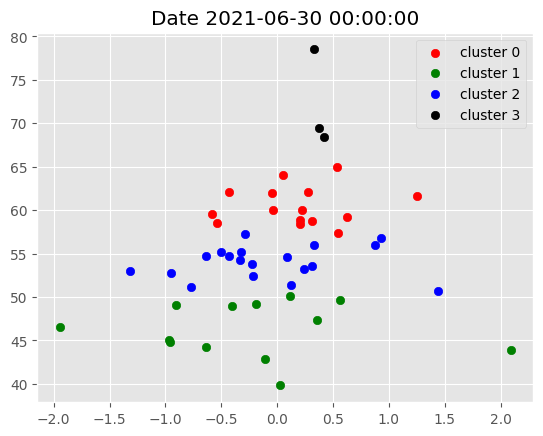

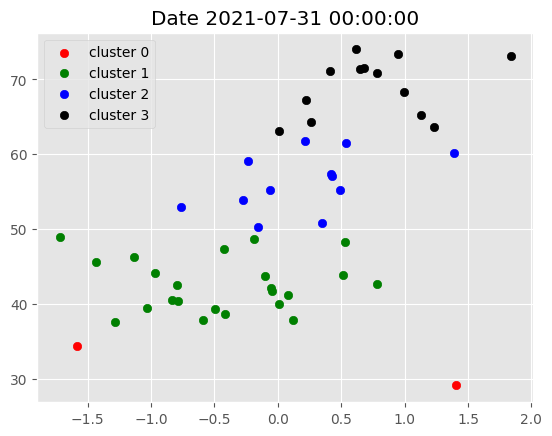

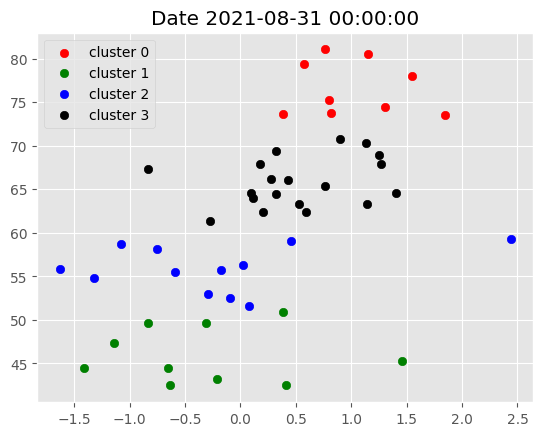

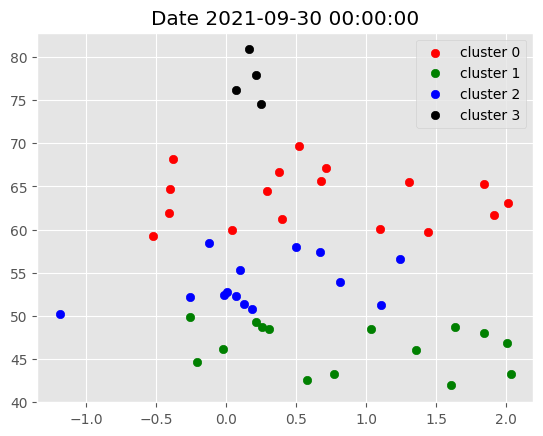

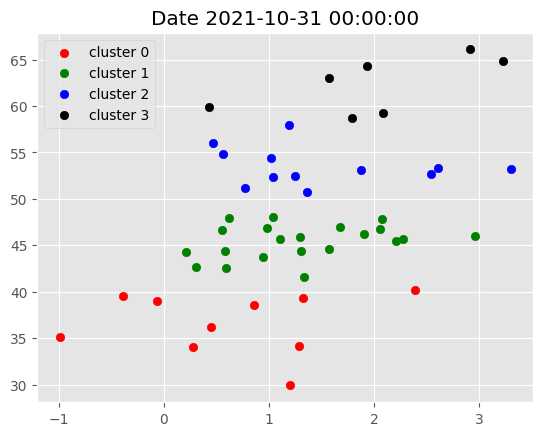

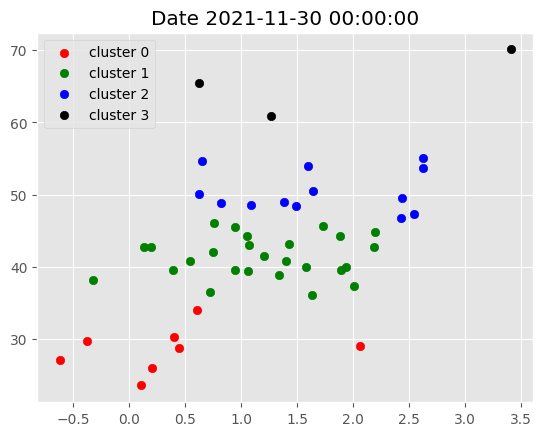

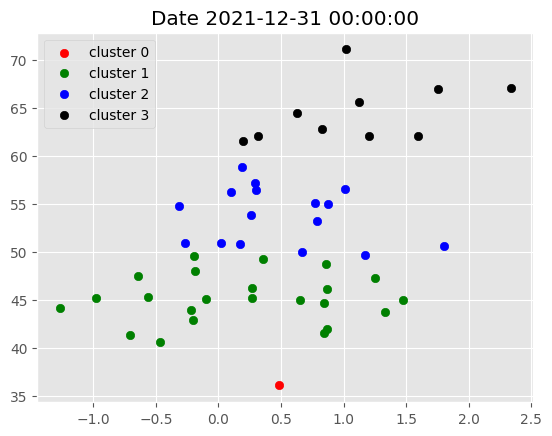

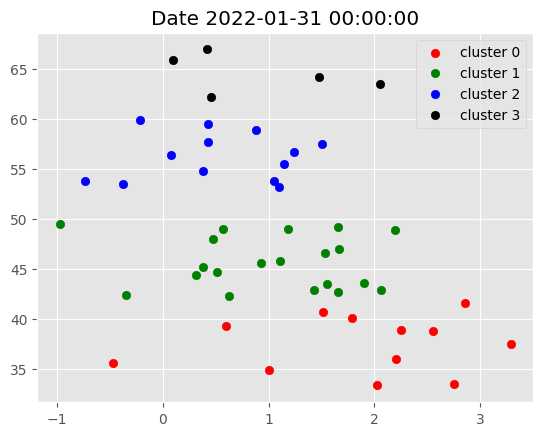

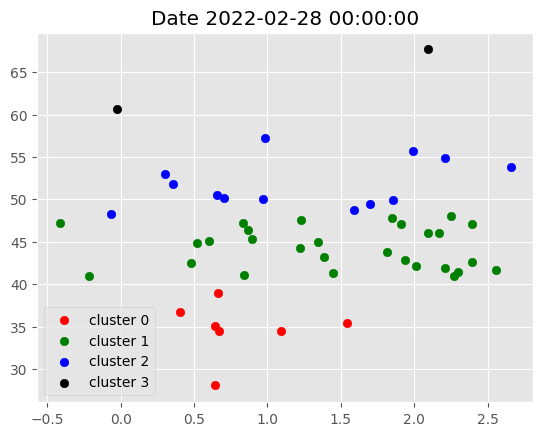

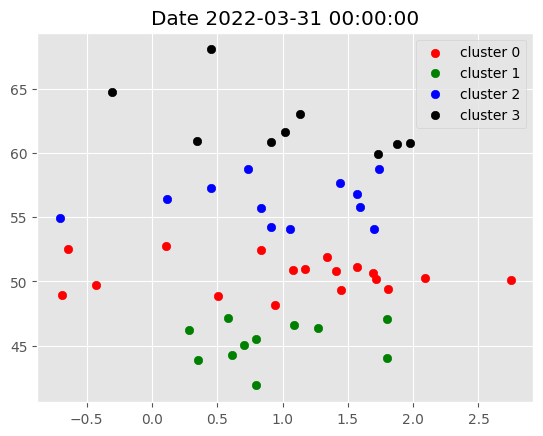

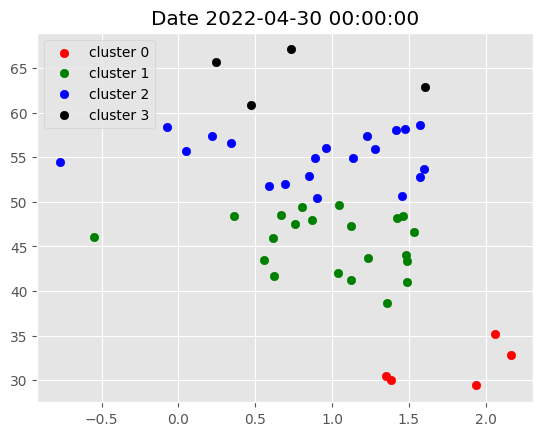

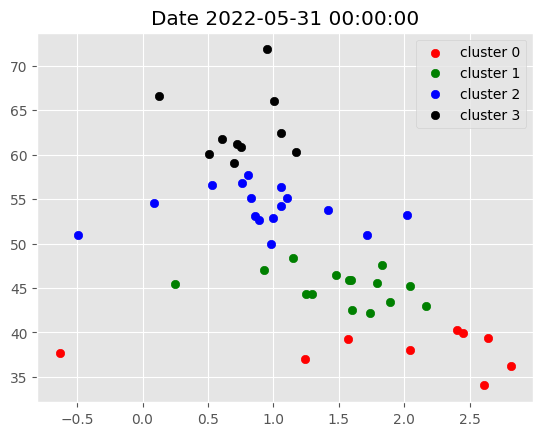

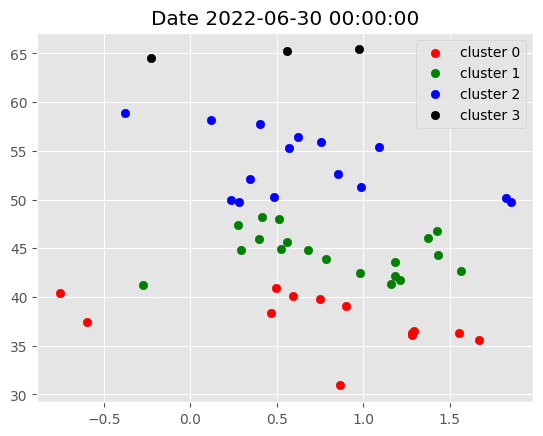

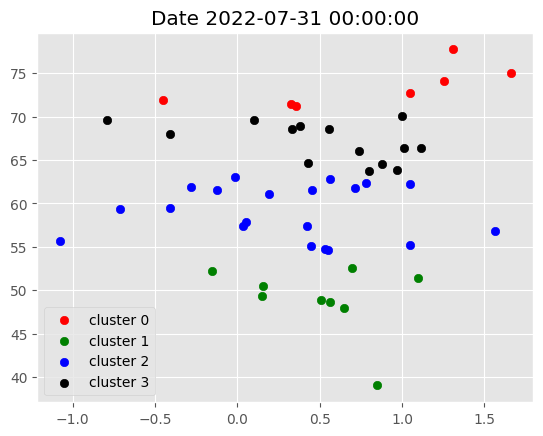

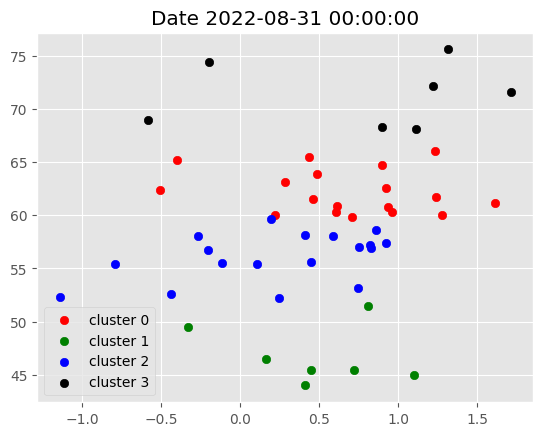

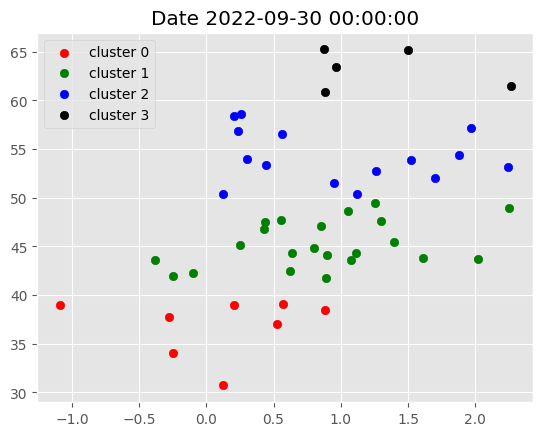

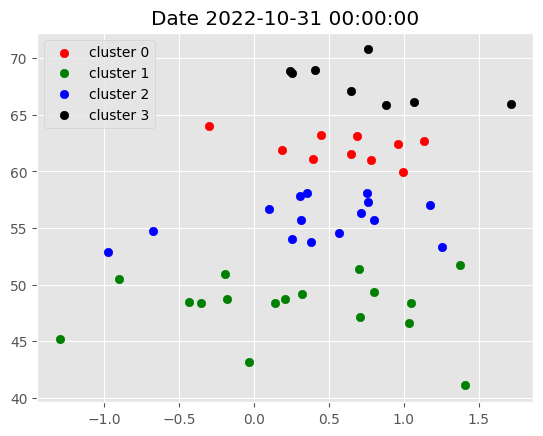

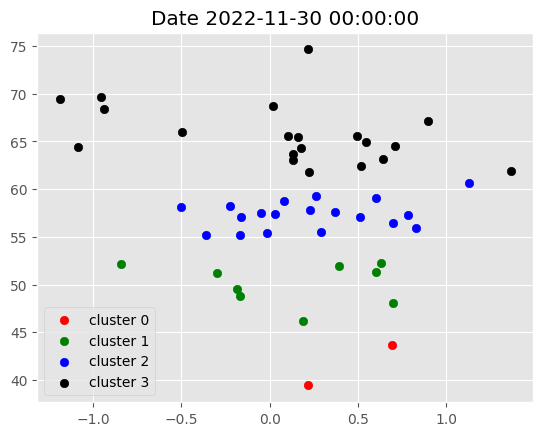

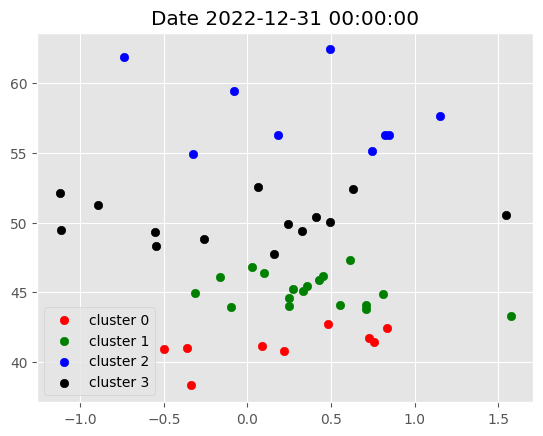

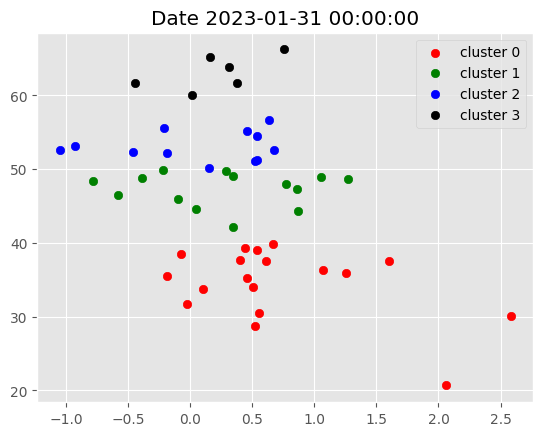

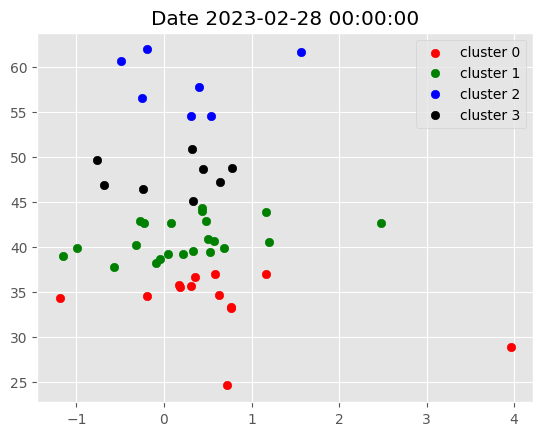

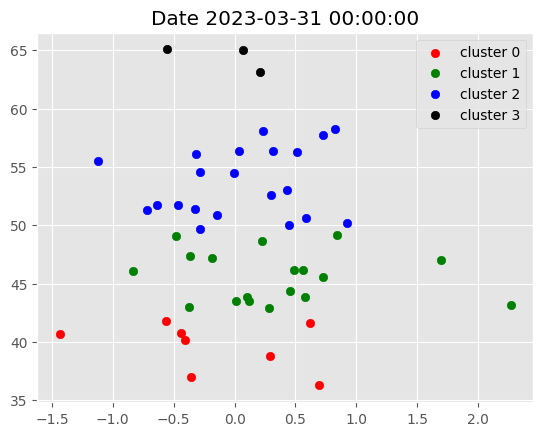

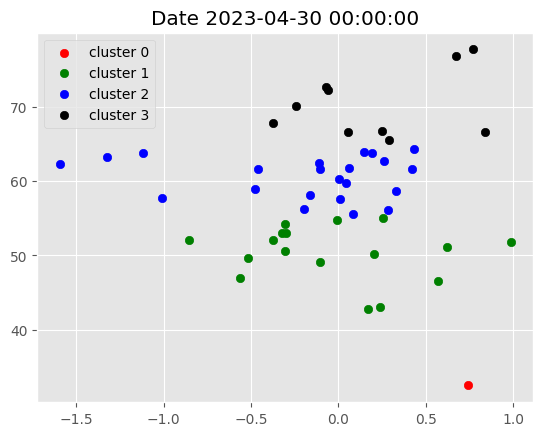

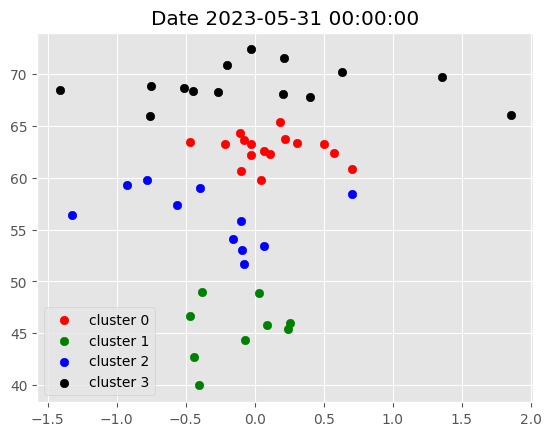

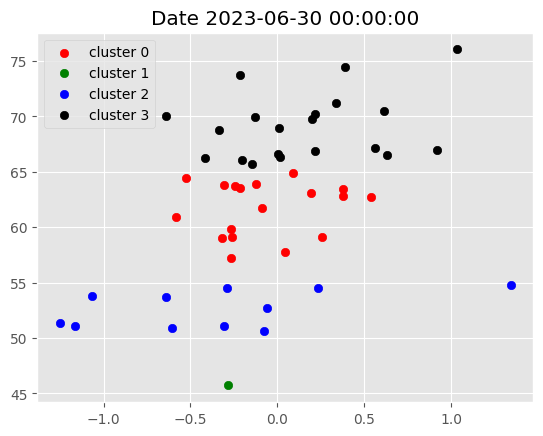

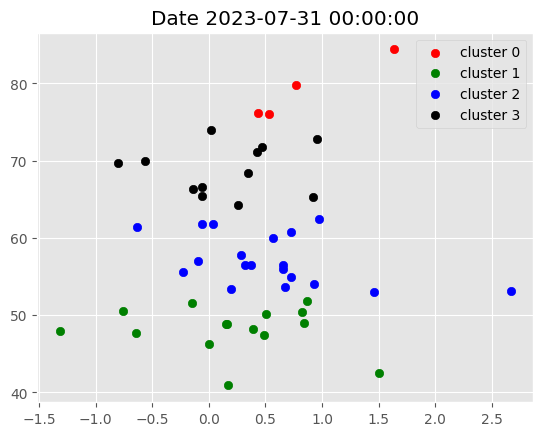

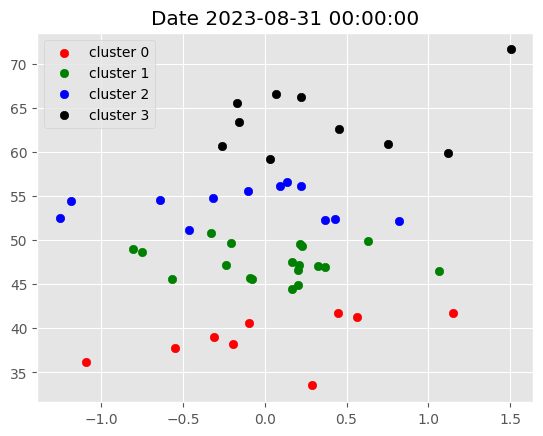

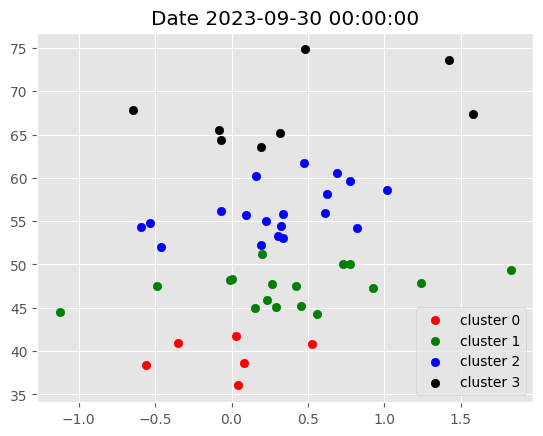

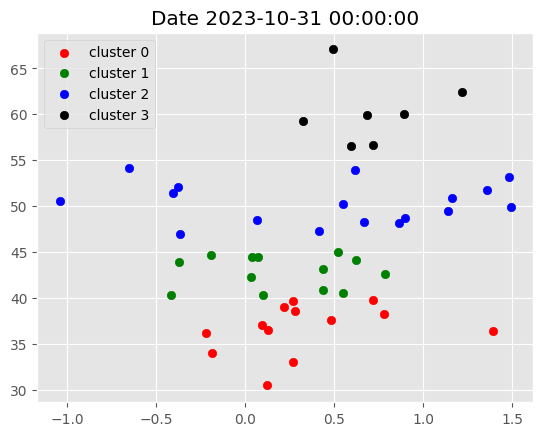

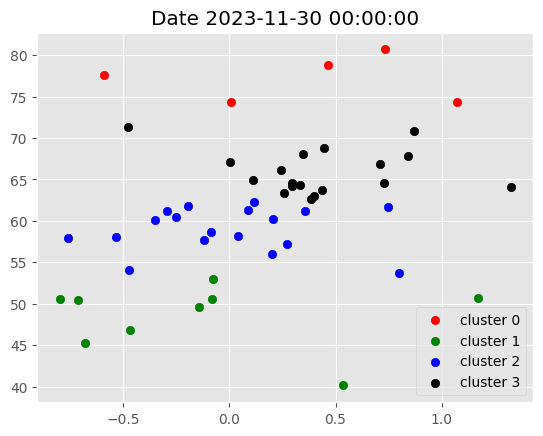

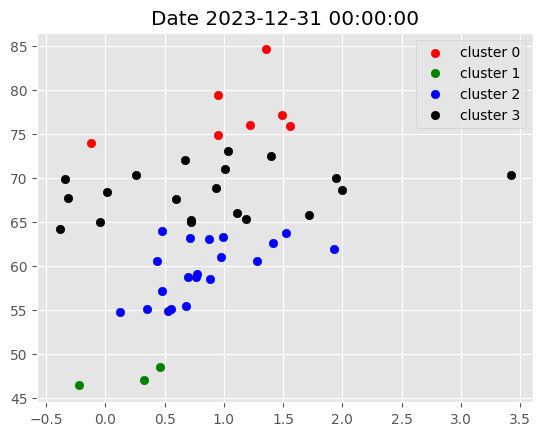

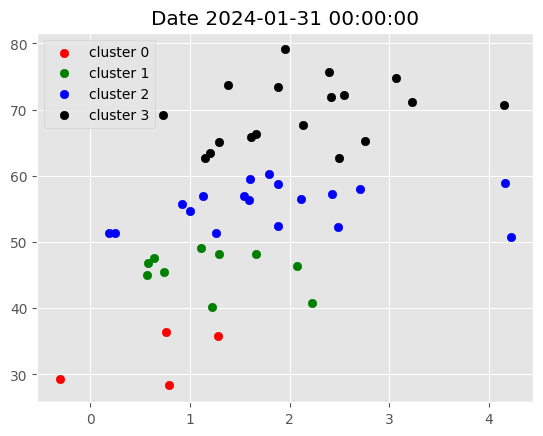

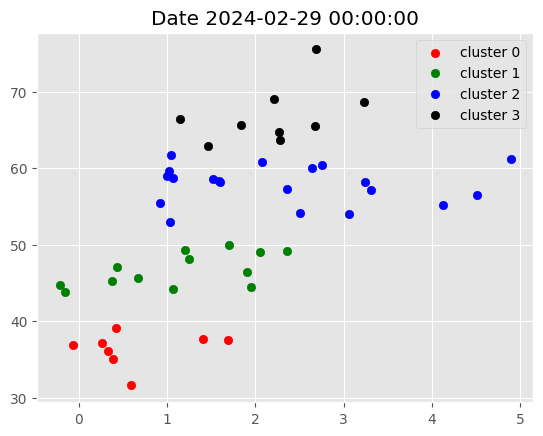

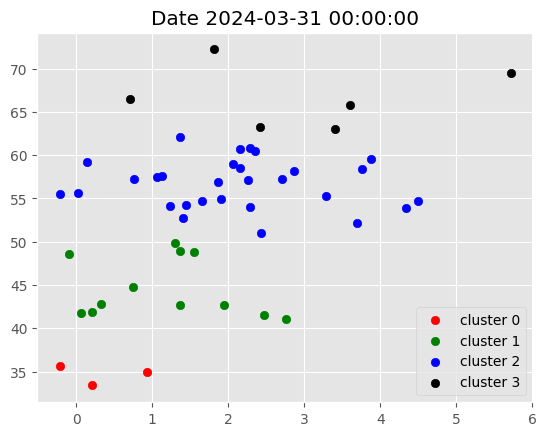

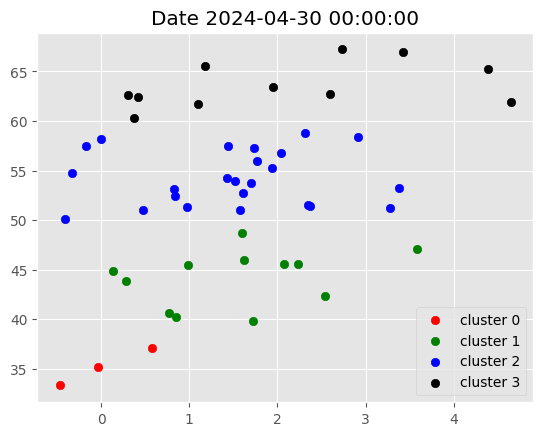

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-06-01': ['HDFCBANK.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'KOTAKBANK.NS',
  'M&M.NS',
  'MARUTI.NS',
  'WIPRO.NS'],
 '2017-07-01': ['BHARTIARTL.NS',
  'GRASIM.NS',
  'HDFCBANK.NS',
  'ITC.NS',
  'TATASTEEL.NS'],
 '2017-08-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BHARTIARTL.NS',
  'BRITANNIA.NS',
  'EICHERMOT.NS',
  'GRASIM.NS',
  'HDFCBANK.NS',
  'HINDALCO.NS',
  'HINDUNILVR.NS',
  'INDUSINDBK.NS',
  'JSWSTEEL.NS',
  'KOTAKBANK.NS',
  'MARUTI.NS',
  'POWERGRID.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TATASTEEL.NS',
  'WIPRO.NS'],
 '2017-09-01': ['BAJAJFINSV.NS',
  'BPCL.NS',
  'BRITANNIA.NS',
  'GRASIM.NS',
  'HINDUNILVR.NS',
  'JSWSTEEL.NS',
  'NESTLEIND.NS',
  'TATACONSUM.NS',
  'TATASTEEL.NS',
  'TITAN.NS',
  'WIPRO.NS'],
 '2017-10-01': ['BAJAJ-AUTO.NS',
  'BRITANNIA.NS',
  'COALINDIA.NS',
  'LTIM.NS',
  'ONGC.NS',
  'TECHM.NS'],
 '2017-11-01': ['ADANIPORTS.NS',
  'BHARTIARTL.NS',
  'ONGC.NS',
  'RELIANCE.NS',
  'TATACON

In [ ]:
pip install PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  50 of 50 completed


Price         Adj Close                                            \
Ticker      ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-05-31    38.895264    184.538010   1335.444336    932.858215   
2016-06-01    40.123260    194.285934   1378.704224    967.762939   
2016-06-02    40.336819    197.071014   1366.950562    969.989075   
2016-06-03    38.468136    196.446793   1332.908325    971.172852   
2016-06-06    38.601620    195.630478   1320.764282    972.120056   
...                 ...           ...           ...           ...   
2024-04-05  3224.800049   1375.550049   6397.750000   2883.449951   
2024-04-08  3224.550049   1348.650024   6307.750000   2892.000000   
2024-04-09  3198.449951   1356.500000   6505.049805   2857.149902   
2024-04-10  3242.000000   1352.300049   6489.850098   2896.750000   
2024-04-12  3209.899902   1344.199951   6406.549805   2854.500000   

Price                                                              \
Ticker      AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-05-31   503.552734   2123.786865    181.568848    744.859924   
2016-06-01   500.376160   2111.984863    179.364853    750.120850   
2016-06-02   512.495850   2104.806641    184.635452    781.740723   
2016-06-03   530.382141   2140.698242    185.074234    775.360840   
2016-06-06   520.803589   2133.236328    186.091461    763.047607   
...                 ...           ...           ...           ...   
2024-04-05  1059.099976   9009.500000   1677.949951   7175.649902   
2024-04-08  1076.050049   9030.500000   1689.150024   7178.549805   
2024-04-09  1080.000000   8978.900391   1710.400024   7193.600098   
2024-04-10  1087.800049   9005.549805   1704.099976   7230.250000   
2024-04-12  1073.449951   9064.849609   1698.650024   7229.549805   

Price                                 ...        Volume               \
Ticker     BHARTIARTL.NS     BPCL.NS  ... SHRIRAMFIN.NS SUNPHARMA.NS   
Date                                  ...                              
2016-05-31    304.174774  208.746857  ...      882332.0     15706495   
2016-06-01    314.432251  210.151993  ...      562680.0      4921709   
2016-06-02    316.985809  213.558350  ...      579247.0      4900285   
2016-06-03    310.017639  215.559601  ...      637086.0      5944789   
2016-06-06    301.880951  214.857285  ...      544642.0      6330743   
...                  ...         ...  ...           ...          ...   
2024-04-05   1191.000000  590.450012  ...      650696.0      1548980   
2024-04-08   1204.699951  591.950012  ...      735781.0      1170390   
2024-04-09   1204.449951  585.750000  ...      953375.0      1389391   
2024-04-10   1229.400024  604.750000  ...      700885.0      1928878   
2024-04-12   1225.550049  601.200012  ...      828911.0      8258068   

Price                                                                  \
Ticker     TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS   
Date                                                                    
2016-05-31        658231     110744326    105401750  3722608  2896981   
2016-06-01        581341      10389215     68046412  1911942  1093756   
2016-06-02        549738      13674434     58494475  1408756  1862166   
2016-06-03       1783456      11672544     92705451  1554922  1706048   
2016-06-06        866406       9356808     52163250  1322026  1614098   
...                  ...           ...          ...      ...      ...   
2024-04-05        627856       4519120     44668121  1636819  1184658   
2024-04-08       1833218       5188052     48255703  2302538   686932   
2024-04-09       1184800       8539041     63884687  1876992  1198161   
2024-04-10       1374918       4554077     64134758  2101965  1994380   
2024-04-12       2006949      11575194     55317636  4354821  2887322   

Price                             

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        print(start_date)

        print(end_date)

        print(cols)

        print(optimization_start_date)

        print(optimization_end_date)


2017-06-01
2017-06-30
['HDFCBANK.NS', 'HEROMOTOCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS', 'KOTAKBANK.NS', 'M&M.NS', 'MARUTI.NS', 'WIPRO.NS']
2016-06-01
2017-05-31
2017-07-01
2017-07-31
['BHARTIARTL.NS', 'GRASIM.NS', 'HDFCBANK.NS', 'ITC.NS', 'TATASTEEL.NS']
2016-07-01
2017-06-30
2017-08-01
2017-08-31
['ADANIPORTS.NS', 'BAJAJFINSV.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HDFCBANK.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'INDUSINDBK.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'MARUTI.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'TATASTEEL.NS', 'WIPRO.NS']
2016-08-01
2017-07-31
2017-09-01
2017-09-30
['BAJAJFINSV.NS', 'BPCL.NS', 'BRITANNIA.NS', 'GRASIM.NS', 'HINDUNILVR.NS', 'JSWSTEEL.NS', 'NESTLEIND.NS', 'TATACONSUM.NS', 'TATASTEEL.NS', 'TITAN.NS', 'WIPRO.NS']
2016-09-01
2017-08-31
2017-10-01
2017-10-31
['BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'COALINDIA.NS', 'LTIM.NS', 'ONGC.NS', 'TECHM.NS']
2016-10-01
2017-09-30
2017-11-01
2017-11-30
['ADANIPORTS.NS', 'B

In [ ]:
optimization_df = new_df['2017-06-01':'2018-05-31']['Adj Close'][fixed_dates['2018-06-01']]

optimization_df

Ticker      ASIANPAINT.NS  BAJAJFINSV.NS  BAJFINANCE.NS  BRITANNIA.NS  \
Date                                                                    
2017-06-01    1107.798218     419.413849    1303.891724   1627.922241   
2017-06-02    1111.473633     429.406525    1337.192505   1621.466553   
2017-06-05    1108.848511     429.301880    1339.010010   1644.806885   
2017-06-06    1100.829712     423.253387    1313.027466   1637.606323   
2017-06-07    1108.800537     424.255676    1319.412598   1644.942749   
...                   ...            ...            ...           ...   
2018-05-25    1238.639404     605.770691    2083.968750   2645.905762   
2018-05-28    1266.913208     599.550171    2063.236816   2652.920898   
2018-05-29    1245.492310     587.428162    2045.657227   2635.735352   
2018-05-30    1240.076782     594.511841    2086.578369   2628.812012   
2018-05-31    1250.428223     602.832520    2077.960693   2689.697998   

Ticker      HDFCBANK.NS  HINDUNILVR.NS  KOTAKBANK.NS      LTIM.NS      M&M.NS  \
Date                                                                            
2017-06-01   775.601562     988.345764    959.194031   715.827087  666.106873   
2017-06-02   778.292236     980.270325    961.784668   708.416565  662.952087   
2017-06-05   778.911377     990.511475    963.528320   707.467651  665.382446   
2017-06-06   780.530579     984.916809    962.930603   710.766174  659.657288   
2017-06-07   781.411621     998.271301    965.172485   724.909180  669.214905   
...                 ...            ...           ...          ...         ...   
2018-05-25   962.976074    1443.920166   1292.006348  1567.723267  809.354309   
2018-05-28   979.036072    1450.426147   1293.302490  1533.550903  802.041199   
2018-05-29   974.433838    1441.125244   1280.440796  1549.898560  821.196960   
2018-05-30   981.984436    1453.129517   1299.384277  1553.915649  847.335632   
2018-05-31  1032.208984    1476.633545   1330.641357  1607.667847  870.926453   

Ticker      NESTLEIND.NS  
Date                      
2017-06-01    604.605103  
2017-06-02    608.517883  
2017-06-05    614.521851  
2017-06-06    611.135559  
2017-06-07    610.458191  
...                  ...  
2018-05-25    900.768066  
2018-05-28    893.758911  
2018-05-29    880.179932  
2018-05-30    881.822388  
2018-05-31    893.291504  

[249 rows x 10 columns]

In [ ]:
weights = optimize_weights(prices = optimization_df, lower_bound = round(1/(len(optimization_df.columns)*2),3))

weights = pd.DataFrame(weights, index=pd.Series(0))

weights

BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  DIVISLAB.NS  EICHERMOT.NS  \
0            0.1            0.1        0.07749      0.07945       0.09806   

   HINDALCO.NS  ICICIBANK.NS  M&M.NS  NTPC.NS  TATAMOTORS.NS  TATASTEEL.NS  
0        0.045           0.1     0.1      0.1            0.1           0.1

In [ ]:
temp_df = returns_dataframe['2018-06-01':'2018-06-30']

temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
       .merge(weights.stack().to_frame('weight').reset_index(level=0 , drop=True),
              left_index = True,
              right_index = True)\
      .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

In [ ]:
weights.stack().to_frame('weight').reset_index(level=0 , drop=True)

weight
ASIANPAINT.NS     0.1
BAJAJFINSV.NS     0.1
BAJFINANCE.NS     0.1
BRITANNIA.NS      0.1
HDFCBANK.NS       0.1
HINDUNILVR.NS     0.1
KOTAKBANK.NS      0.1
LTIM.NS           0.1
M&M.NS            0.1
NESTLEIND.NS      0.1

In [ ]:
temp_df.index.names = ['Date', 'Ticker']

temp_df

return  weight
Date       Ticker                         
2018-06-01 ASIANPAINT.NS -0.008931     0.1
           BAJAJFINSV.NS -0.026845     0.1
           BAJFINANCE.NS -0.015523     0.1
           BRITANNIA.NS  -0.019001     0.1
           HDFCBANK.NS   -0.013576     0.1
...                            ...     ...
2018-06-29 HINDUNILVR.NS  0.023676     0.1
           KOTAKBANK.NS   0.002871     0.1
           LTIM.NS        0.017929     0.1
           M&M.NS        -0.011133     0.1
           NESTLEIND.NS   0.003840     0.1

[210 rows x 2 columns]

In [ ]:
temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

temp_df

return  weight  weighted_return
Date       Ticker                                          
2018-06-01 ASIANPAINT.NS -0.008931     0.1        -0.000893
           BAJAJFINSV.NS -0.026845     0.1        -0.002685
           BAJFINANCE.NS -0.015523     0.1        -0.001552
           BRITANNIA.NS  -0.019001     0.1        -0.001900
           HDFCBANK.NS   -0.013576     0.1        -0.001358
...                            ...     ...              ...
2018-06-29 HINDUNILVR.NS  0.023676     0.1         0.002368
           KOTAKBANK.NS   0.002871     0.1         0.000287
           LTIM.NS        0.017929     0.1         0.001793
           M&M.NS        -0.011133     0.1        -0.001113
           NESTLEIND.NS   0.003840     0.1         0.000384

[210 rows x 3 columns]

In [ ]:
temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

Strategy Return
Date                       
2018-06-01        -0.014297
2018-06-04        -0.011429
2018-06-05        -0.003965
2018-06-06         0.011534
2018-06-07         0.012426
2018-06-08        -0.002911
2018-06-11         0.005462
2018-06-12         0.003731
2018-06-13        -0.003345
2018-06-14         0.000806
2018-06-15         0.004257
2018-06-18        -0.007723
2018-06-19        -0.006110
2018-06-20         0.005616
2018-06-21        -0.002397
2018-06-22         0.012474
2018-06-25         0.002080
2018-06-26         0.000400
2018-06-27        -0.003399
2018-06-28        -0.004046
2018-06-29         0.004200

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        weights = optimize_weights(prices=optimization_df,
                              lower_bound=round(1/(len(optimization_df.columns)*2),3))

        weights = pd.DataFrame(weights, index=pd.Series(0))

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: inf

<Axes: xlabel='date'>

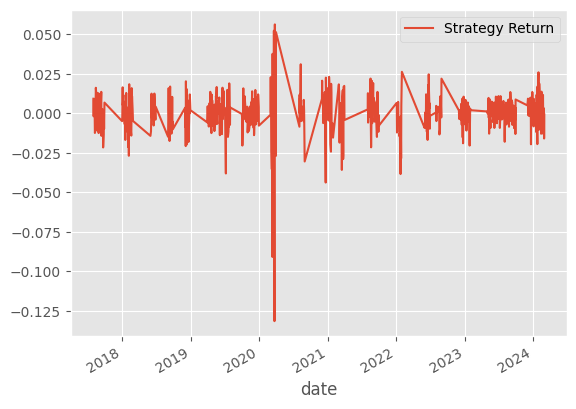

In [ ]:
portfolio_df.plot()

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df



Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-06-01         0.001133
2017-06-02         0.005370
2017-06-05         0.003990
2017-06-06        -0.004205
2017-06-07         0.006371
...                     ...
2024-04-05        -0.012628
2024-04-08         0.010101
2024-04-09        -0.001040
2024-04-10         0.000821
2024-04-12        -0.015114

[1696 rows x 1 columns]

<Axes: xlabel='date'>

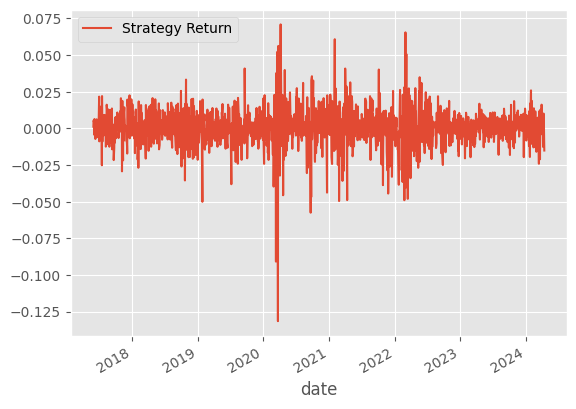

In [ ]:
portfolio_df.plot()

In [ ]:
nft = yf.download(tickers='^NSEI',
                  start='2016-06-01',
                  end=dt.date.today())

nft_ret = np.log(nft[['Adj Close']]).diff().dropna().rename({'Adj Close':'^NSEI Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nft_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  ^NSEI Buy&Hold
2017-06-01         0.001133       -0.000535
2017-06-02         0.005370        0.003882
2017-06-05         0.003990        0.002235
2017-06-06        -0.004205       -0.003930
2017-06-07         0.006371        0.002772
...                     ...             ...
2024-04-05        -0.012628       -0.000042
2024-04-08         0.010101        0.006755
2024-04-09        -0.001040       -0.001040
2024-04-10         0.000821        0.004892
2024-04-12        -0.015114       -0.010355

[1692 rows x 2 columns]

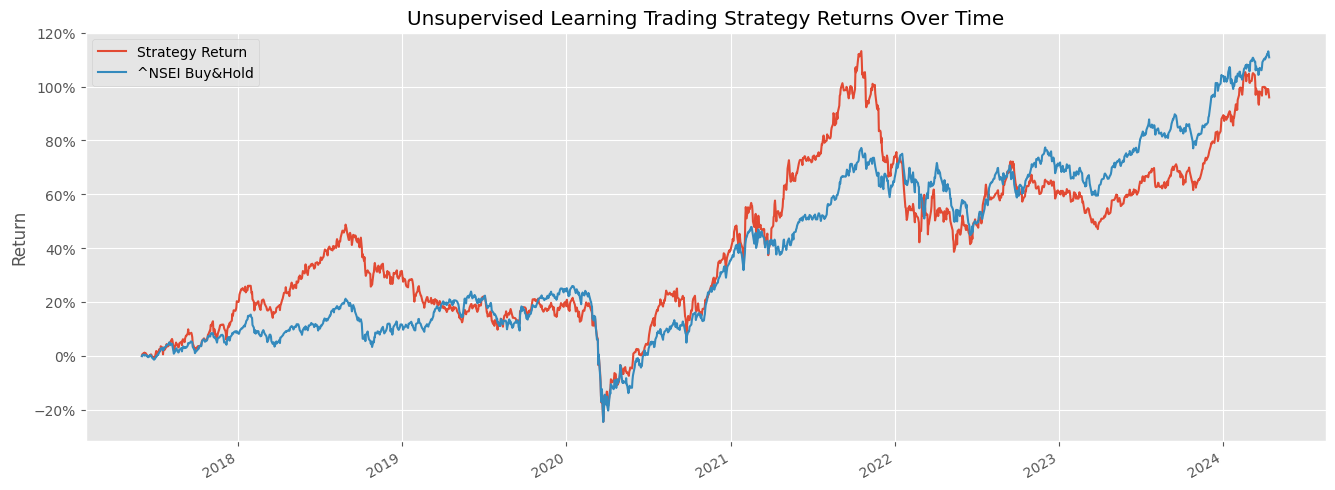

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-04-14'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()